<a href="https://colab.research.google.com/github/tusharganguli/anomaly_detection/blob/main/ad_multiclassifier_diabetes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

References:

* [Diabetes( Three Ensemble Models )](https://www.kaggle.com/code/ohseokkim/diabetes-three-ensemble-models#Ensemble)

#Load Data

In [4]:
"""
!pip install seaborn_qqplot
!pip install pycaret
!pip install scipy
!pip install shap
"""

'\n!pip install seaborn_qqplot\n!pip install pycaret\n!pip install scipy\n!pip install shap\n'

In [5]:
from matplotlib import rcParams
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


In [6]:
# Load the dataset
df = pd.read_csv('drive/MyDrive/Completumhealth/diabetes/diabetes.csv')

# rename the DiabetesPedigreeFunction column
df.rename(columns ={"DiabetesPedigreeFunction":"DPF"},inplace=True)
feature_names = [cname for cname in df.loc[:,:'Age'].columns]

#Exploratory Data Analysis

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Pregnancies    768 non-null    int64  
 1   Glucose        768 non-null    int64  
 2   BloodPressure  768 non-null    int64  
 3   SkinThickness  768 non-null    int64  
 4   Insulin        768 non-null    int64  
 5   BMI            768 non-null    float64
 6   DPF            768 non-null    float64
 7   Age            768 non-null    int64  
 8   Outcome        768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [8]:
df.describe()

Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   
min       0.000000    0.000000       0.000000       0.000000    0.000000   
25%       1.000000   99.000000      62.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI         DPF         Age     Outcome  
count  768.000000  768.000000  768.000000  768.000000  
mean    31.992578    0.471876   33.240885    0.348958  
std      7.884160    0.331329   11.760232    0.476951  
min      0.000000    0.078000   21.000000    0.000000  
25%     27.300000    0.243750   24.000000    0.000000  
50%     32.000000    0.372500   29.000000    0.000000  
75%     36.600000    0.626250   41.000000    1.000000  
max     67.100000    2.420000   81.000000    1.000000

In [9]:
df.isna().sum()

Pregnancies      0
Glucose          0
BloodPressure    0
SkinThickness    0
Insulin          0
BMI              0
DPF              0
Age              0
Outcome          0
dtype: int64

There are no missing values.

In [10]:
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DPF', 'Age', 'Outcome'],
      dtype='object')

In [11]:
print('Not Diabetic', round(df['Outcome'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Diabetic', round(df['Outcome'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

Not Diabetic 65.1 % of the dataset
Diabetic 34.9 % of the dataset


Text(0.5, 1.0, 'Class Distributions \n (0: Not Diabetic || 1: Diabetic)')

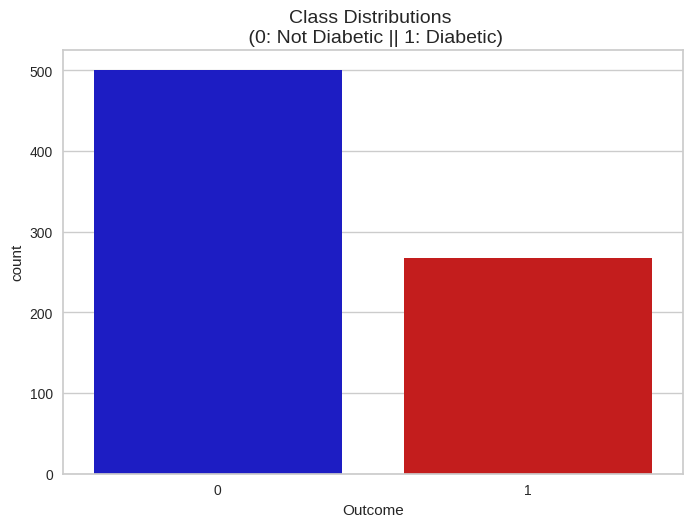

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

colors = ["#0101DF", "#DF0101"]

sns.countplot(x='Outcome', data=df, palette=colors)
plt.title('Class Distributions \n (0: Not Diabetic || 1: Diabetic)', fontsize=14)

The classes are not heavily skewed. We have good representation of diabetic and non-diabetic people.

**Distributions**:

We can observe the distributions of individual columns and determine how skewed are they.

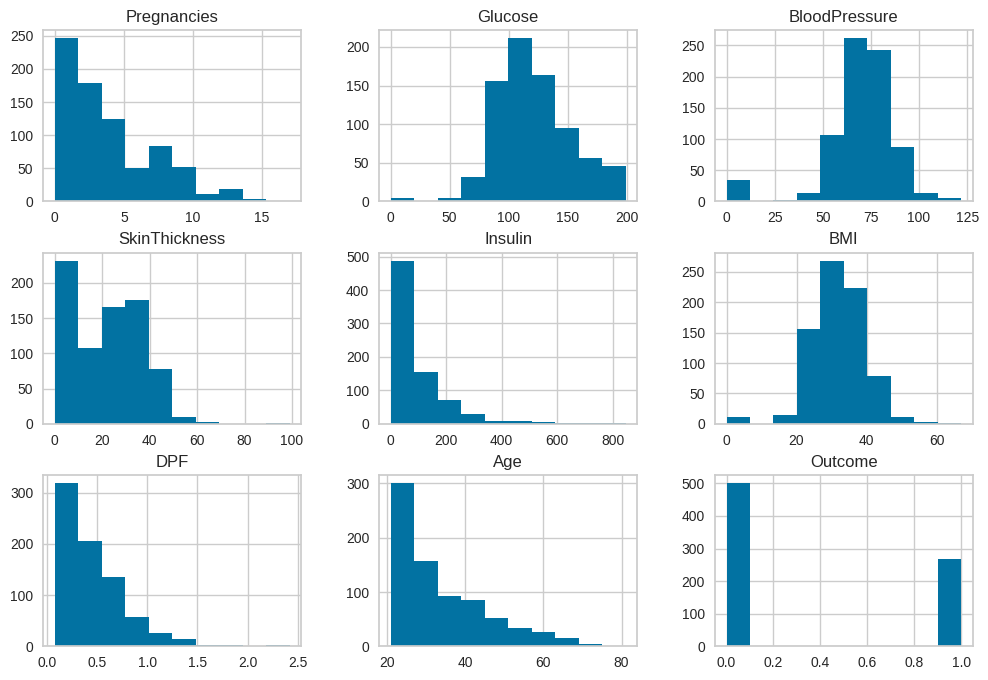

In [13]:
df.hist(figsize=(12, 8))
plt.show()

**Data Statistics**

In [14]:
def compute_stat(df):
  # Column names
  columns = ['Feature','Mean', 'Std', 'Skewness','Kurtosis']
  df_stats = pd.DataFrame(columns=columns)

  for column in df.columns:
      mean = df[column].mean()
      std = df[column].std()
      skew = df[column].skew()
      kurtosis = df[column].kurtosis()
      df_stats.loc[len(df_stats)] = [column, mean,std,skew,kurtosis]
      #print(column+':')
      #print('mean: {0:.4f}, std: {1:.4f}, skew: {2:.4f}, kurtosis: {3:.4f} '.format(mean, std, skew, kurtosis))
  return df_stats

df_stats = compute_stat(df)
print(df_stats)

         Feature        Mean         Std  Skewness  Kurtosis
0    Pregnancies    3.845052    3.369578  0.901674  0.159220
1        Glucose  120.894531   31.972618  0.173754  0.640780
2  BloodPressure   69.105469   19.355807 -1.843608  5.180157
3  SkinThickness   20.536458   15.952218  0.109372 -0.520072
4        Insulin   79.799479  115.244002  2.272251  7.214260
5            BMI   31.992578    7.884160 -0.428982  3.290443
6            DPF    0.471876    0.331329  1.919911  5.594954
7            Age   33.240885   11.760232  1.129597  0.643159
8        Outcome    0.348958    0.476951  0.635017 -1.600930


## Skewness and Kurtosis in Data Distributions

**Skewness** and **kurtosis** are statistical measures that provide insights into the shape of a data distribution. Understanding their effects can guide data transformation decisions, especially for models assuming normally distributed errors.

### Skewness

- **Definition**: Skewness gauges the distribution's asymmetry. A distribution is:
  - Left-skewed if the value is negative.
  - Right-skewed if positive.
  - Symmetric if close to zero.
  
#### Impact of Skewness in Classification

In classification, skewness can refer to the distribution of feature values or the distribution of class labels. The implications of skewness in each context are:

#### 1. Feature Skewness

- **Nature of Algorithms**: Some algorithms, particularly parametric ones like logistic regression or linear discriminant analysis, assume specific distributions for feature values. Skewed distributions can violate these assumptions and potentially degrade model performance.
  
- **Scale and Distribution**: Algorithms sensitive to feature scale and distribution, such as k-nearest neighbors (due to its distance-based nature) and neural networks (due to gradient descent dynamics), can be affected by skewed features. Transformations to address skewness can be beneficial in these cases.
  
- **Interpretability**: For some algorithms like tree-based methods (e.g., decision trees, random forests), the skewness of features might not directly impact performance. However, reducing skewness can enhance feature interpretability and ensure consistent data preprocessing.

#### 2. Class Label Skewness (Class Imbalance)

- **Performance Metrics**: In scenarios with significant class imbalance, accuracy might not be a reliable metric. For example, with 95% of instances in Class A and 5% in Class B, a naive model predicting only Class A would have a 95% accuracy but might not be genuinely useful.
  
- **Model Bias**: Models can become biased towards the majority class, leading to poor recall for the minority class. This bias is especially problematic in contexts like fraud detection, where detecting the minority class (frauds) is crucial.
  
- **Mitigation Strategies**: Addressing class imbalance can involve techniques like oversampling the minority class, undersampling the majority class, generating synthetic data using methods like SMOTE, or adjusting class weights in the algorithm.

In conclusion, skewness can play a pivotal role in classification tasks, depending on the specific algorithm and context. Being cognizant of skewness and its potential impacts is essential for informed model development and evaluation.




### Kurtosis

- **Definition**: Kurtosis evaluates the "tailedness" of a distribution. Compared to a normal distribution (with a kurtosis of 3):
  - High kurtosis indicates heavier tails, implying more outliers.
  - Low kurtosis suggests lighter tails.
  - "Excess kurtosis" is often mentioned, calculated as kurtosis minus 3.
  
- **Impact**: High kurtosis can be an issue for models assuming normally distributed errors due to the presence of more outliers.

### Impact of Kurtosis in Classification

Kurtosis is a statistical measure that describes the "tailedness" of a distribution. In the context of classification, kurtosis can pertain to the distribution of feature values. Let's delve into the implications:

### 1. Feature Kurtosis

- **Heavy Tails & Outliers**: High kurtosis indicates that the distribution has heavier tails than a normal distribution. This suggests a higher likelihood of outliers. Outliers can particularly influence algorithms sensitive to extreme values, like SVM with certain kernels or linear models.

- **Light Tails**: Low kurtosis suggests the distribution has lighter tails than a normal distribution, implying fewer extreme values or outliers.

- **Algorithm Implications**: While tree-based algorithms (e.g., decision trees, random forests) are generally robust to outliers, linear models and distance-based algorithms (like k-nearest neighbors) can be significantly influenced by them. High kurtosis might be a sign to investigate potential outliers or extreme values that could adversely affect such models.

- **Transformations**: For distributions with high kurtosis and discernible outliers, transformations (like log, Box-Cox, or Yeo-Johnson) or robust scaling methods can help in mitigating the effect of outliers and make the data more amenable to certain algorithms.

### 2. Class Label Kurtosis

- **Relevance**: Kurtosis typically applies to continuous data distributions. In classification, class labels are categorical, so kurtosis isn't directly applicable. However, the concept of having extreme values or rare categories can be analogously considered, leading to concerns of class imbalance.

In conclusion, while kurtosis itself might not be a primary concern in classification, the implications of high kurtosis—especially the presence of outliers—can be essential. Recognizing and addressing the effects of extreme feature values can be pivotal for the success of various classification algorithms.


### Tolerable Value Range

- **Skewness**:
  - Between -0.5 and 0.5: fairly symmetrical.
  - Between -1 and -0.5 (or 0.5 and 1): moderate skewness.
  - Outside -1 and 1: high skewness.

- **Kurtosis** (Excess Kurtosis):
  - Close to 0: similar to a normal distribution.
  - Greater than 0: more outliers than a normal distribution.
  - Less than 0: fewer outliers than a normal distribution.

### Caveats

- While these ranges serve as guidelines, they aren't hard rules. Skewness and kurtosis's effect varies depending on the model and application.
- Visualization tools like histograms, Q-Q plots, or P-P plots offer more insights into distribution.
- Not all algorithms mandate normally distributed data. For instance, tree-based algorithms often don't.

### Addressing Skewness and Kurtosis

- Transformations like logarithmic, square root, Box-Cox, or Yeo-Johnson can mitigate skewness and kurtosis.
- Detecting and handling outliers can particularly help when high kurtosis stems from extreme values.

Remember: While skewness and kurtosis offer valuable insights, actions should be dictated by the specific algorithm needs, problem context, and the model's empirical performance on validation data.


In [15]:
def kurtosis_warning(val):
  if -0.5 < val < 0.5:
    color = "green"
  if val > .5:
    color = 'blue'
  if val < -.5:
    color = "cyan"
  return f'color: {color}'

def skew_warning(val):
  if -0.5 < val < 0.5:
    color = "green"
  if -1 < val < -0.5 or 0.5 < val < 1:
    color = 'yellow'
  if val < -1 or val > 1:
    color = "red"
  return f'color: {color}'

df_styled = (df_stats.style.applymap(skew_warning, subset=['Skewness']).applymap(kurtosis_warning, subset=['Kurtosis']))
df_styled

For Skewness:
* <font color="green">Green</font>: Fairly symmetrical.
* <font color="yellow">Yellow</font>: Moderate skewness.
* <font color="red">Red</font>: High skewness.

For Kurtosis:
* <font color="green">Green</font>: Similar to a normal distribution.
* <font color="blue">Blue</font>: More outliers than a normal distribution.
* <font color="cyan">Cyan</font>: Fewer outliers than a normal distribution.

**Note**: Removing outliers of columns would help the ML model to better learn the features and their correlation. It should be done contextually and should not entail in removing outliers blindly from all columns.

## Correlation

### Importance of Correlation Matrix in Binary Classification

The correlation matrix, visualized as a heatmap, quantifies the linear relationships between pairs of features. In binary classification, understanding these relationships offers several advantages:

- Feature Selection
  - Multicollinearity: Features with high inter-correlations can introduce instability in certain algorithms. Recognizing and handling these can improve model robustness.
  - Redundancy: Highly correlated features may carry redundant information. Removing one can reduce dimensionality without significant loss of information.

- Feature Engineering Insights
  - Highly correlated features can hint at opportunities for new feature creation, potentially enhancing predictive power.

- Detecting Data Issues
 - Unexpected correlations can signal data problems, like leakage, where a predictor inadvertently contains information about the target.

- Understanding the Target
 - Examining each feature's correlation with the target provides an initial gauge of its potential predictive importance.

- Algorithmic Efficiency
 - Some algorithms benefit from feature independence. Identifying and handling correlated features can improve performance.

**Points to Remember**:
- Nature of Correlation: Pearson correlation measures linear relationships. Non-linear relationships may need other methods for detection.
- Correlation ≠ Causation: A correlation doesn't imply a causal relationship.
- Binary Features: For binary features in binary classification, consider using point-biserial correlation.

In essence, while invaluable, the correlation matrix is among many tools used in data preprocessing for binary classification.


In [16]:
df.corr()

Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin  \
Pregnancies       1.000000  0.129459       0.141282      -0.081672 -0.073535   
Glucose           0.129459  1.000000       0.152590       0.057328  0.331357   
BloodPressure     0.141282  0.152590       1.000000       0.207371  0.088933   
SkinThickness    -0.081672  0.057328       0.207371       1.000000  0.436783   
Insulin          -0.073535  0.331357       0.088933       0.436783  1.000000   
BMI               0.017683  0.221071       0.281805       0.392573  0.197859   
DPF              -0.033523  0.137337       0.041265       0.183928  0.185071   
Age               0.544341  0.263514       0.239528      -0.113970 -0.042163   
Outcome           0.221898  0.466581       0.065068       0.074752  0.130548   

                    BMI       DPF       Age   Outcome  
Pregnancies    0.017683 -0.033523  0.544341  0.221898  
Glucose        0.221071  0.137337  0.263514  0.466581  
BloodPressure  0.281805  0.041265  0.239528  0.065068  
SkinThickness  0.392573  0.183928 -0.113970  0.074752  
Insulin        0.197859  0.185071 -0.042163  0.130548  
BMI            1.000000  0.140647  0.036242  0.292695  
DPF            0.140647  1.000000  0.033561  0.173844  
Age            0.036242  0.033561  1.000000  0.238356  
Outcome        0.292695  0.173844  0.238356  1.000000

###Pair Plots or Scatter Matrix:

To visualize pair-wise relationships and histograms for multiple numerical variables.

### Pair Plots (Scatter Matrices)

A pair plot, often referred to as a scatter matrix in certain tools, is a matrix layout of scatter plots, showcasing the relationship between two variables. This visualization offers a comprehensive depiction of pairwise relationships and distributions in a dataset.

### Key Insights from Pair Plots:

1. **Relationships between Variables**: The off-diagonal subplots depict scatter plots for two distinct variables for discerning linear or non-linear correlations, anomalies, or clusters.

2. **Distribution of Individual Variables**: Diagonal plots (often histograms or Kernel Density Estimates in tools like seaborn) display the distribution of individual variables.

3. **Comparison Across Classes**: Categorical variable (Outcome), allow coloring by class using the `hue` parameter. This helps in observing how different classes exhibit clustering behavior across features.

4. **Visual Correlation Indication**: Though scatter plots don't provide quantitative correlation values, visible patterns can hint at potential correlations.

5. **Spotting Outliers**: Outliers or anomalies might become evident through scatter plots.

### Points to Consider:

- **Dimensionality**: With numerous features, pair plots can become cluttered and less intuitive.
- **Overplotting**: With large datasets, overplotting can occur where data points overlap, obscuring distribution. Techniques like point transparency, hexbin plots, or 2D KDE plots can help.
- **Applicability**: These plots are ideal for numeric data and aren't tailored for categorical variables. However, categorically coloring data points can enhance insights.

In essence, during the exploratory data analysis phase, pair plots serve as invaluable tools for gleaning insights and guiding further feature engineering or analysis.


<Figure size 1000x800 with 0 Axes>

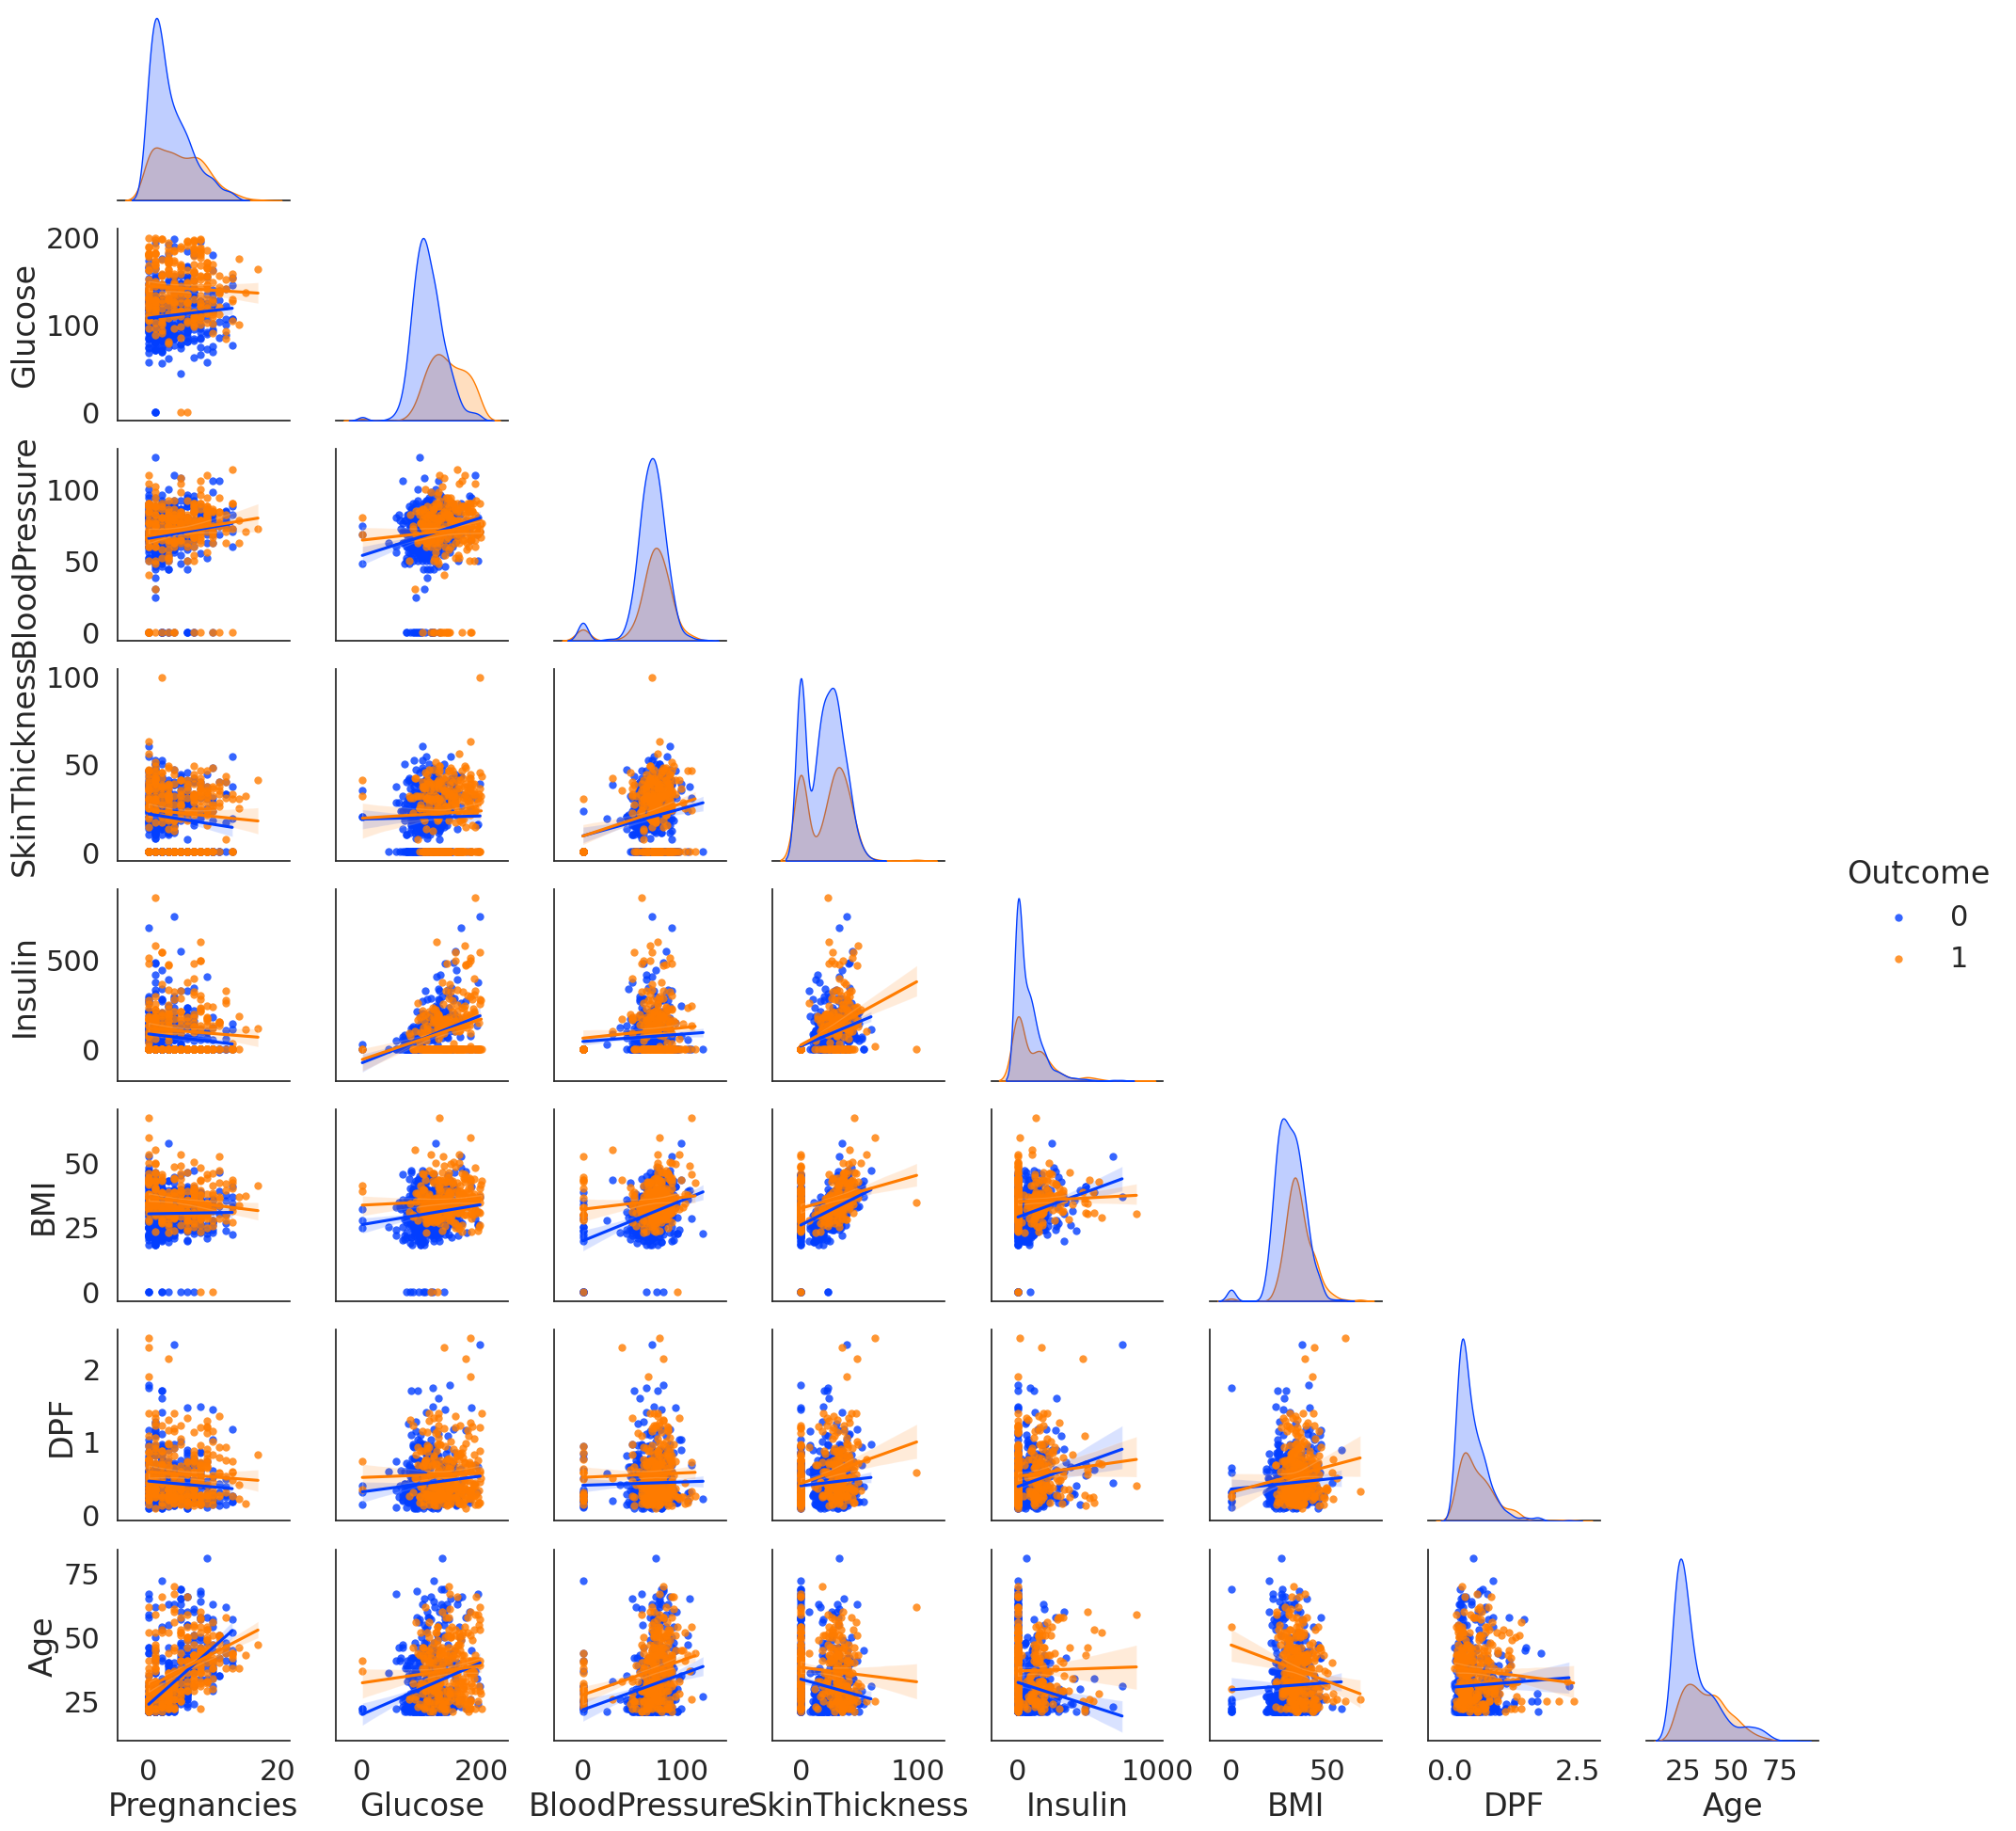

In [17]:
import seaborn as sns
#sns.pairplot(df)

sns.set(font_scale=2)
plt.figure(figsize=(10, 8))
sns.set_style("white")
sns.set_palette("bright")
sns.pairplot(df,kind = 'reg',corner = True,hue="Outcome")


###Heatmaps

To visualize the correlation matrix.

Text(0.5, 1.0, 'Correlation Plot')

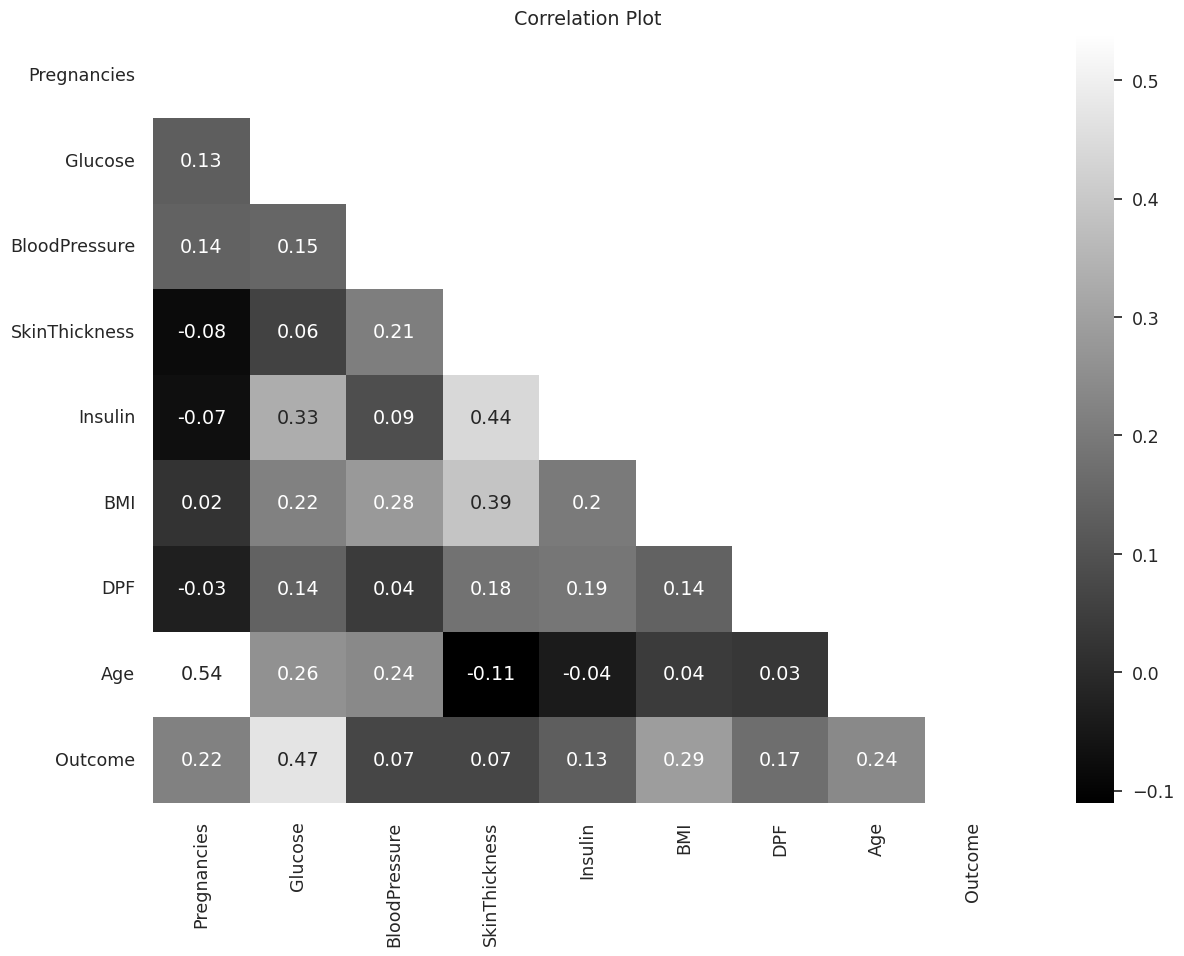

In [18]:
#sns.heatmap(df.corr())

corr=df.corr().round(2)

sns.set(font_scale=1.15)
plt.figure(figsize=(14, 10))
sns.set_palette("bright")
sns.set_style("white")
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr,annot=True,cmap='gist_yarg_r',mask=mask,cbar=True)
plt.title('Correlation Plot')

In [19]:
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DPF', 'Age', 'Outcome'],
      dtype='object')

Consider the last row or the last column of the correlation matrix which shows the correlation of outcome to other features. It is indicative that the outcome is directly correlated to Pregnancies, Glucose, Insulin, BMI, DPF and Age.

##Box Plots

To identify outliers and understand the spread of data.

A box plot, also known as a box-and-whisker plot, is a graphical representation of a dataset's five-number summary: the minimum, first quartile (Q1), median (Q2 or second quartile), third quartile (Q3), and maximum. It provides a visual summary of the data's distribution, spread, skewness, and the presence of outliers. Here's a detailed breakdown of what a box plot tells us:

**Components of a Box Plot**

1. **Box**: The central box represents the interquartile range (IQR), which is the range between the first quartile (25th percentile) and the third quartile (75th percentile).

2. **Whiskers**: The lines extending from the box, known as whiskers, indicate variability outside the IQR. They can either represent a specific percentile or extend to the minimum or maximum data values that are not considered outliers.

  * whis : float or (float, float), default: 1.5
  
    The position of the whiskers. If a float, the lower whisker is at the lowest datum above Q1 - whis*(Q3-Q1), and the upper whisker at the highest datum below Q3 + whis*(Q3-Q1), where Q1 and Q3 are the first and third quartiles.

    The default value of whis = 1.5 corresponds to Tukey's original definition of boxplots.

3. **Median Line**: A line within the box marks the median of the data.

4. **Outliers**: Data points that fall far from the other data points may be plotted individually and are considered outliers.

**What It Tells Us**

1. Central Tendency: The line inside the box shows the median of the dataset, providing an idea of the dataset's central tendency.

2. Variability/Spread: The length of the box (IQR) and whiskers indicate the spread of the data. A longer box or whiskers suggest higher variability, while shorter ones imply lower variability.

3. Symmetry and Skewness:

  * If median is centrally located within box, data is roughly symmetrical.
  * If median is closer to bottom of the box, data is positively skewed.
  * If median is closer to the top, data is negatively skewed.

4. Outliers: Points that are plotted individually outside the whiskers are potential outliers. These can indicate anomalies or errors in the data.

5. Comparison Across Groups: When multiple box plots are displayed side-by-side, you can compare the distributions of different groups easily. This is useful for observing relationships between a numerical variable and a categorical variable.

6. Detection of Anomalies: Extremely long or uneven whiskers, or an asymmetric box, can indicate potential issues with the data collection process or the presence of extreme values affecting the data distribution.

7. Quantiles: The quartiles (Q1 and Q3) provide additional information on data distribution. For instance, if Q1 is closer to the median than Q3, it indicates that the lower half of the dataset is more condensed compared to the upper half.

8. Tail Length: The length of the whiskers can indicate the "heaviness" of the tails in the distribution. Long whiskers suggest long tails, and short whiskers suggest short tails.

In summary, a box plot is a powerful tool for quickly visualizing complex datasets, providing insights into the data's shape, variability, central tendency, and outliers.

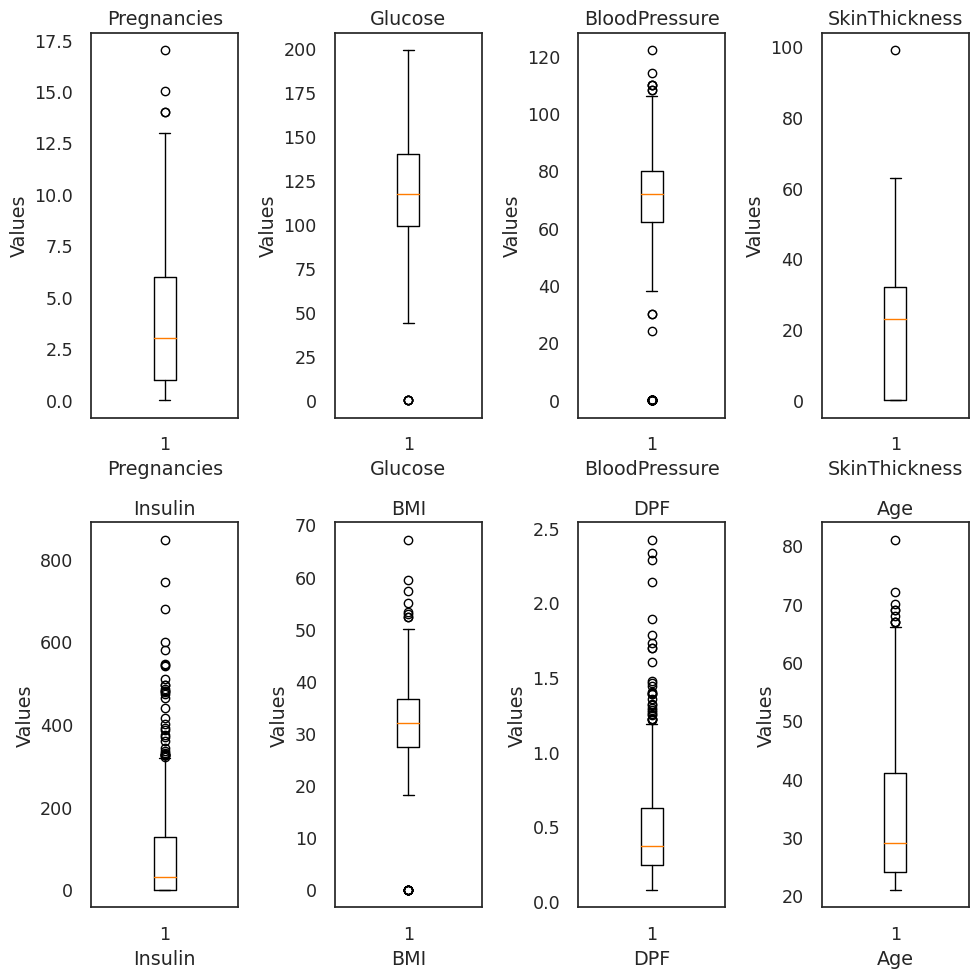

In [20]:
import numpy as np

# Number of columns and rows for the subplot array
n_cols = 4
n_rows = int(np.ceil( (len(df.columns)-1) / n_cols))
# Create a figure and an array of subplots with 2 rows
fig, ax = plt.subplots(n_rows, n_cols, figsize=(10, 10))

# Flatten the array of subplots if necessary
ax = ax.flatten()

# Loop through each column and each subplot
for i, column in enumerate(df.columns):
    if column == "Outcome":
      continue
    ax[i].boxplot(df[column])  # Create the boxplot
    ax[i].set_title(f"{column}")  # Set the title
    ax[i].set_xlabel(column)  # Set the x-axis label
    ax[i].set_ylabel('Values')  # Set the y-axis label

# Remove any unused subplots
for i in range(len(df.columns), n_cols * n_rows):
    fig.delaxes(ax[i])

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()  # Show the plot

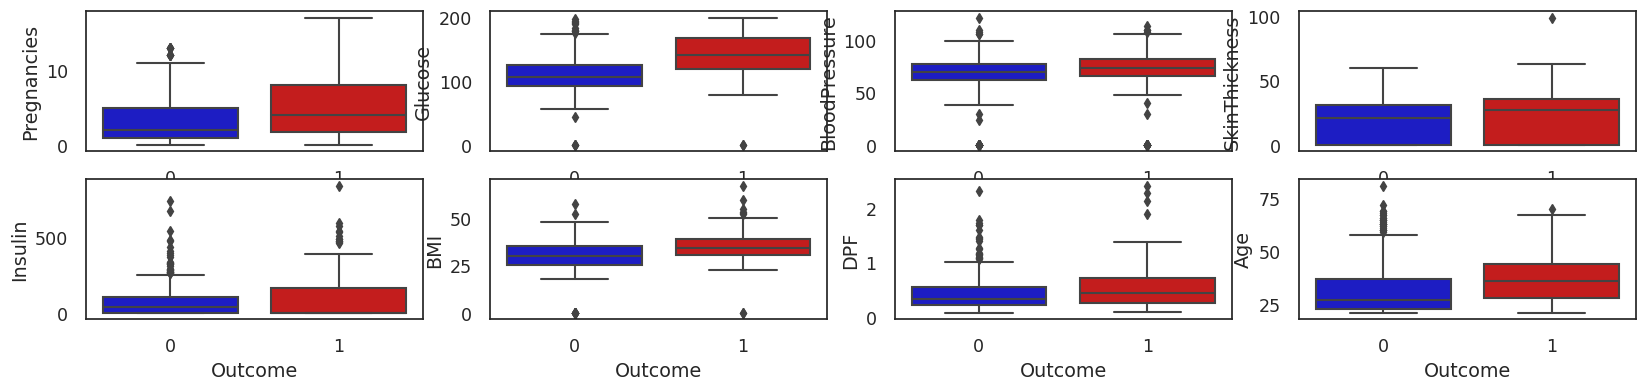

In [21]:
f, axes = plt.subplots(nrows=2,ncols=4, figsize=(20,4))

for i,column in enumerate(df.columns):
  if column != 'Outcome':
    sns.boxplot(x="Outcome", y=column, data=df, palette=colors, ax=axes[int(i/4),i%4])

#Checking and Removing Outliers

In [22]:
def histplot(df):
  rcParams['figure.figsize'] = 40,60
  sns.set(font_scale = 3)
  sns.set_style("white")
  sns.set_palette("bright")
  plt.subplots_adjust(hspace=0.5)
  i = 1;
  for name in feature_names:
      plt.subplot(5,2,i)
      sns.histplot(data=df, x=name, hue="Outcome",kde=True,palette="YlGnBu")
      i = i + 1

Logically zero values do not make sense for most of the columns, they are effectively missing values. We shall peplace the zero values with the mean values of the corresponding column.  

Logically, pregnancies can be 0 hence we will not replace these zeros.

In [23]:
zero_features = ['Glucose','BloodPressure','SkinThickness',"Insulin",'BMI']
total_count = df.shape[0]

print("Proportion of Zeros:")
for feature in zero_features:
    zero_count = df[df[feature]==0].shape[0]
    pcent = zero_count/total_count * 100
    print('{0}: {1}, {2:.2f}%'.format(feature, zero_count, pcent))

Proportion of Zeros:
Glucose: 5, 0.65%
BloodPressure: 35, 4.56%
SkinThickness: 227, 29.56%
Insulin: 374, 48.70%
BMI: 11, 1.43%


In [24]:
mean = df[zero_features].mean()
df[zero_features]=df[zero_features].replace(0, mean)

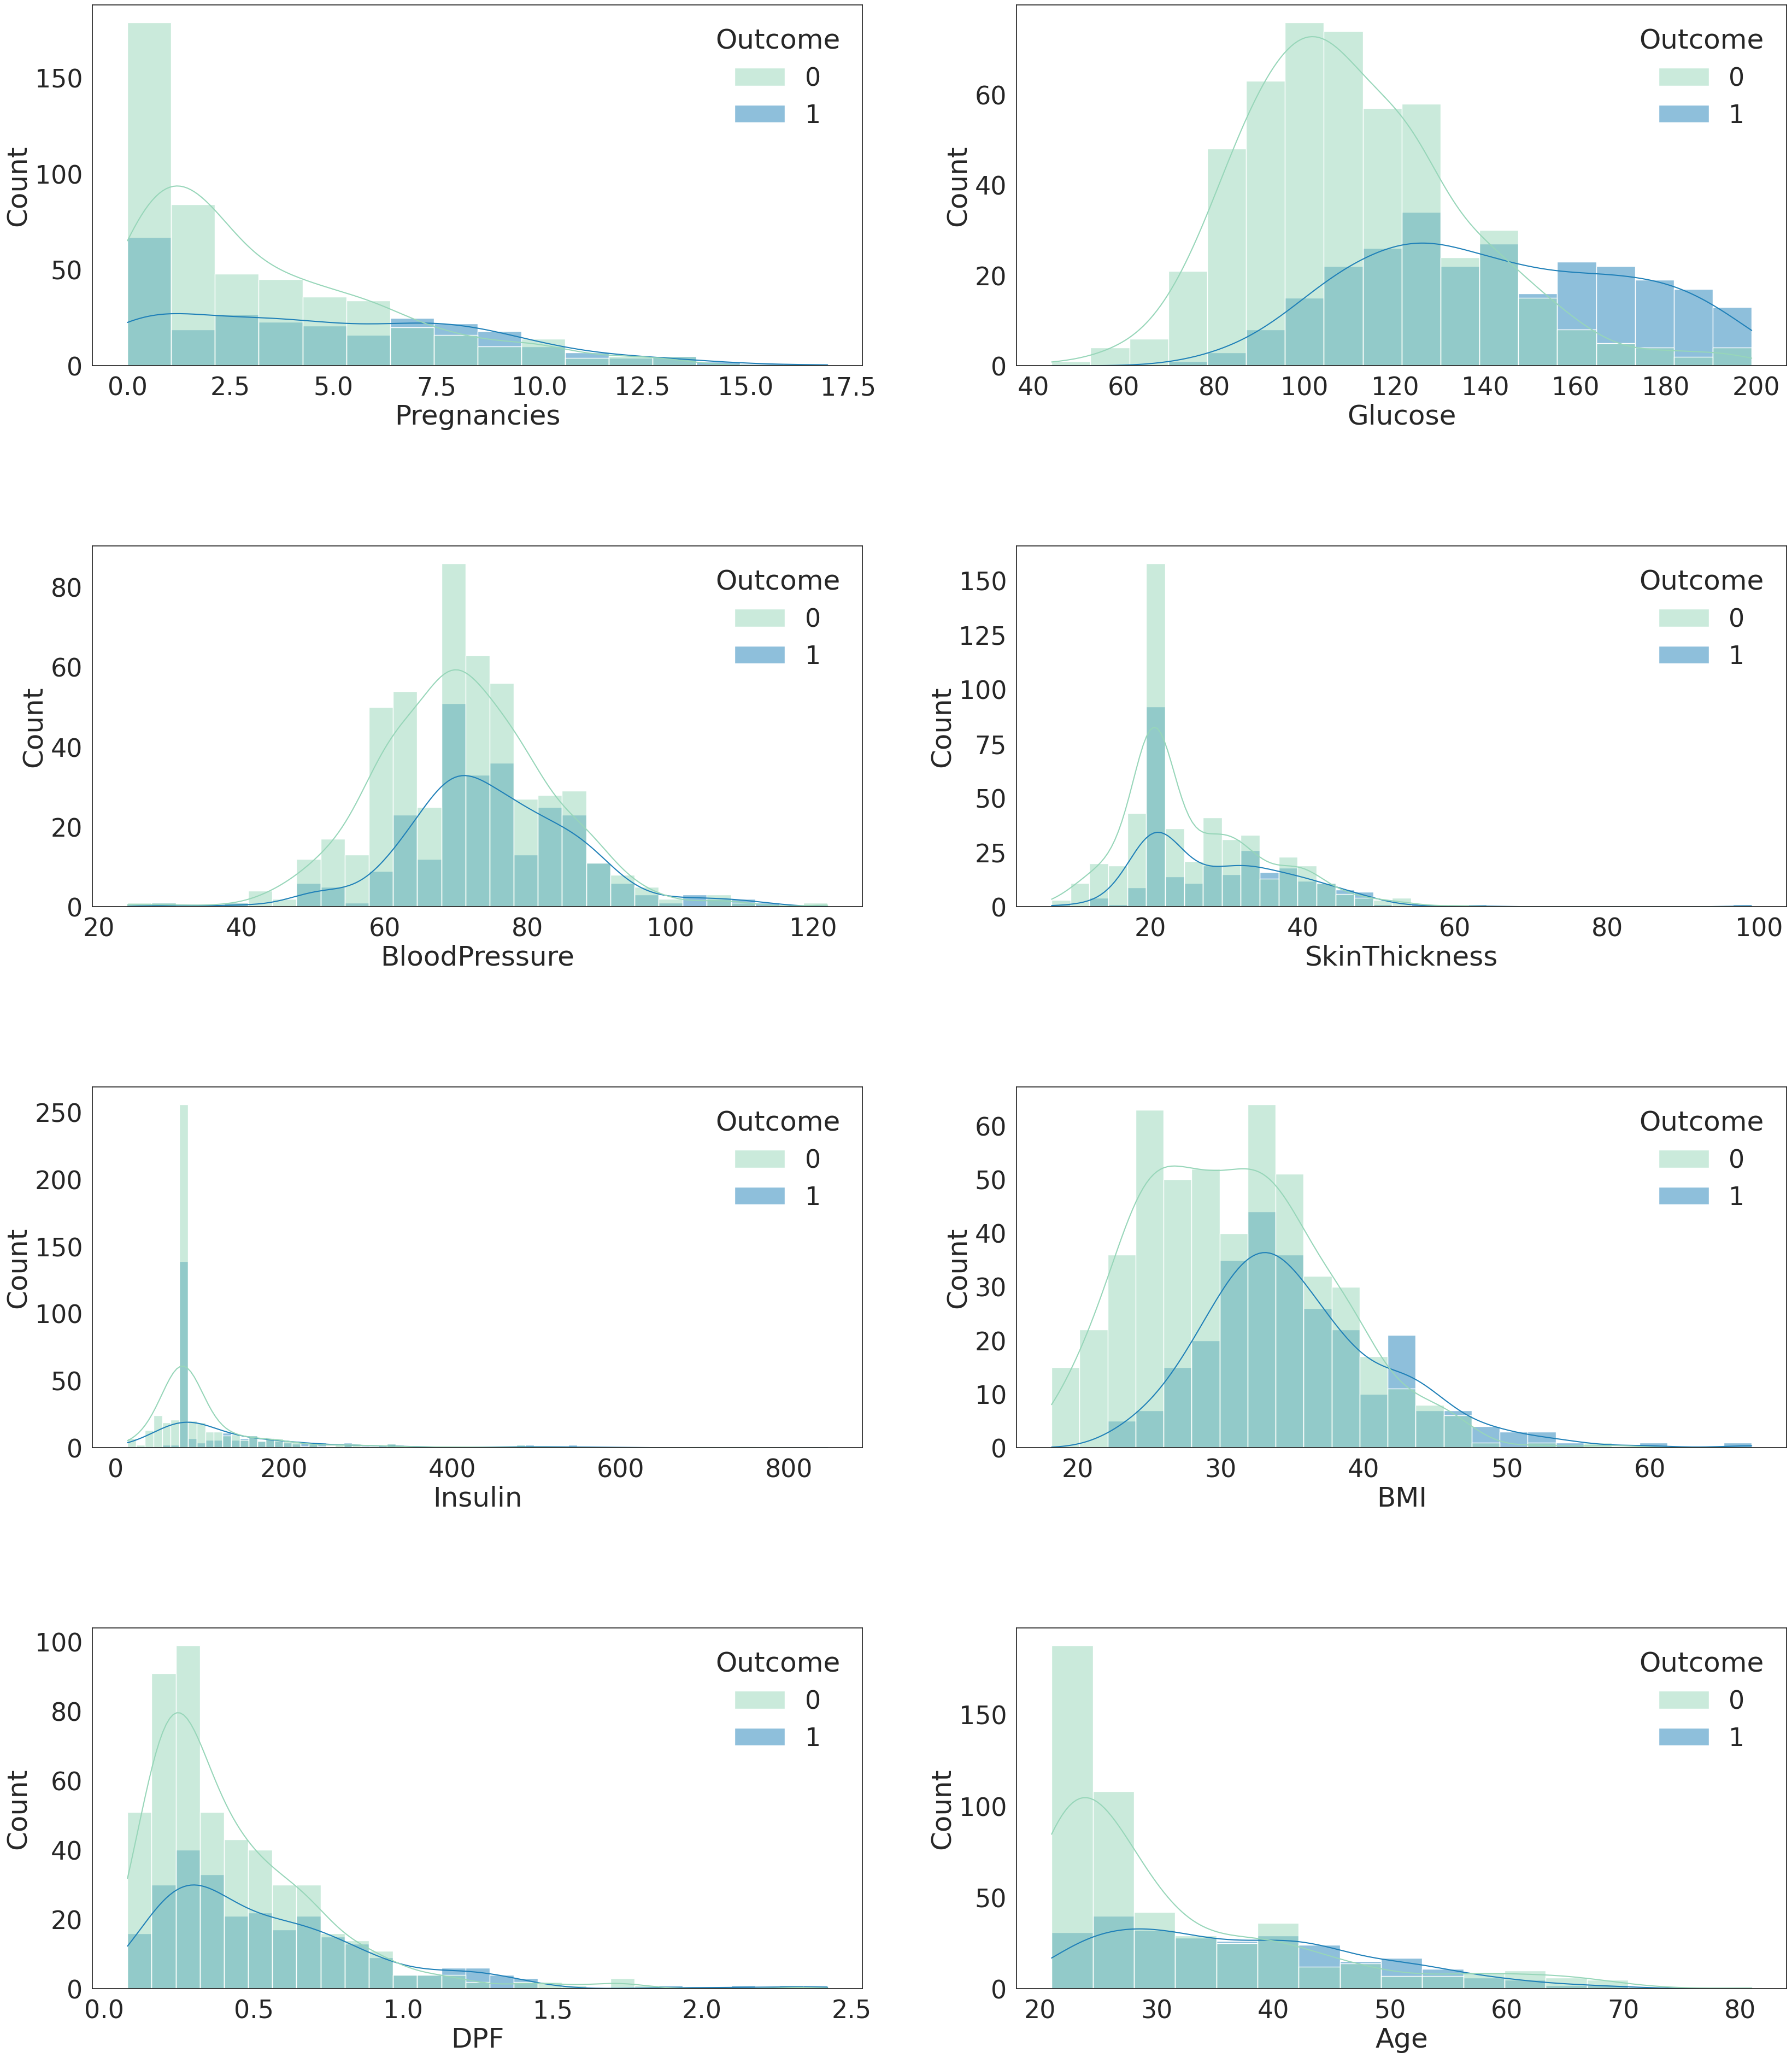

In [25]:
histplot(df)

In [26]:
df_stats2 = compute_stat(df)
df_styled2 = (df_stats2.style.applymap(skew_warning, subset=['Skewness']).applymap(kurtosis_warning, subset=['Kurtosis']))
df_styled2

#Scaling

## Quantile Transformation

### What is a Quantile?

A quantile is a data point or set of data points that partition your data into "parts" of equal probability. For instance:
- The median splits your data into two equal parts, with 50% of the data below and 50% above. It's also known as the 50th percentile or 0.5 quantile.
- Quartiles divide your data into four parts: the first quartile (25th percentile or 0.25 quantile) has 25% of the data below it.
- Percentiles divide your data into 100 equal parts.

### Quantile Transformation:

Quantile transformation, often called quantile normalization, involves converting the distribution of a given dataset to follow another specific distribution, commonly the standard normal distribution. The transformation is achieved by mapping the quantiles of the input data to the quantiles of the desired distribution.

#### Steps involved in Quantile Transformation:
1. **Rank Data**: Rank the data points in the column or feature you wish to transform.
2. **Map to Uniform Distribution**: Convert the ranks to the range [0, 1]. This step effectively maps your data to a uniform distribution.
3. **Map to Desired Distribution**: Convert the uniformly distributed data to your target distribution, usually a standard normal distribution. This is done by applying the inverse of the cumulative distribution function (CDF) of the target distribution.

### Why use Quantile Transformation?
1. **Distributional Assumptions**: Some machine learning algorithms and statistical methods work best when the input features are normally distributed. Quantile transformation can help meet this assumption.
2. **Outlier Handling**: By its nature, quantile transformation can reduce the impact of outliers. Outliers get mapped to values closer to the bulk of the data than they were before the transformation.
3. **Homogenize Variances**: Quantile transformation can lead to homogenized variances across features, which can be beneficial for some algorithms.

### Caveats:
1. **Interpretability**: Post-transformation, the data might lose its original interpretability. For instance, a transformed age column might no longer represent ages in a recognizable way.
2. **Invariance**: The transformation is not invariant to the number of samples. Adding or removing samples can change the transformation.


In [27]:
from sklearn.preprocessing import QuantileTransformer

X = df.iloc[:,:-1]
y = df.iloc[:,-1]

# During initial quantile tranformation of all columns we found that pregnancy
# and age do not correspond to the normal distribution. Quantile transformation
# in those columns increased skewness and kurtosis of those columns.
# Hence we are not going to process them.

# Remove and store columns
cols_to_remove = ['Pregnancies', 'Age']
stored_cols_data = {col: (X.columns.get_loc(col), X.pop(col)) for col in cols_to_remove}

scaler = QuantileTransformer(n_quantiles=100, random_state=0, output_distribution='normal')
X_scaled = scaler.fit_transform(X)

df_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# Add stored columns back to their original positions
for col, (idx, ser) in stored_cols_data.items():
    df_scaled.insert(idx, col, ser)

df_scaled["Outcome"] = df["Outcome"]


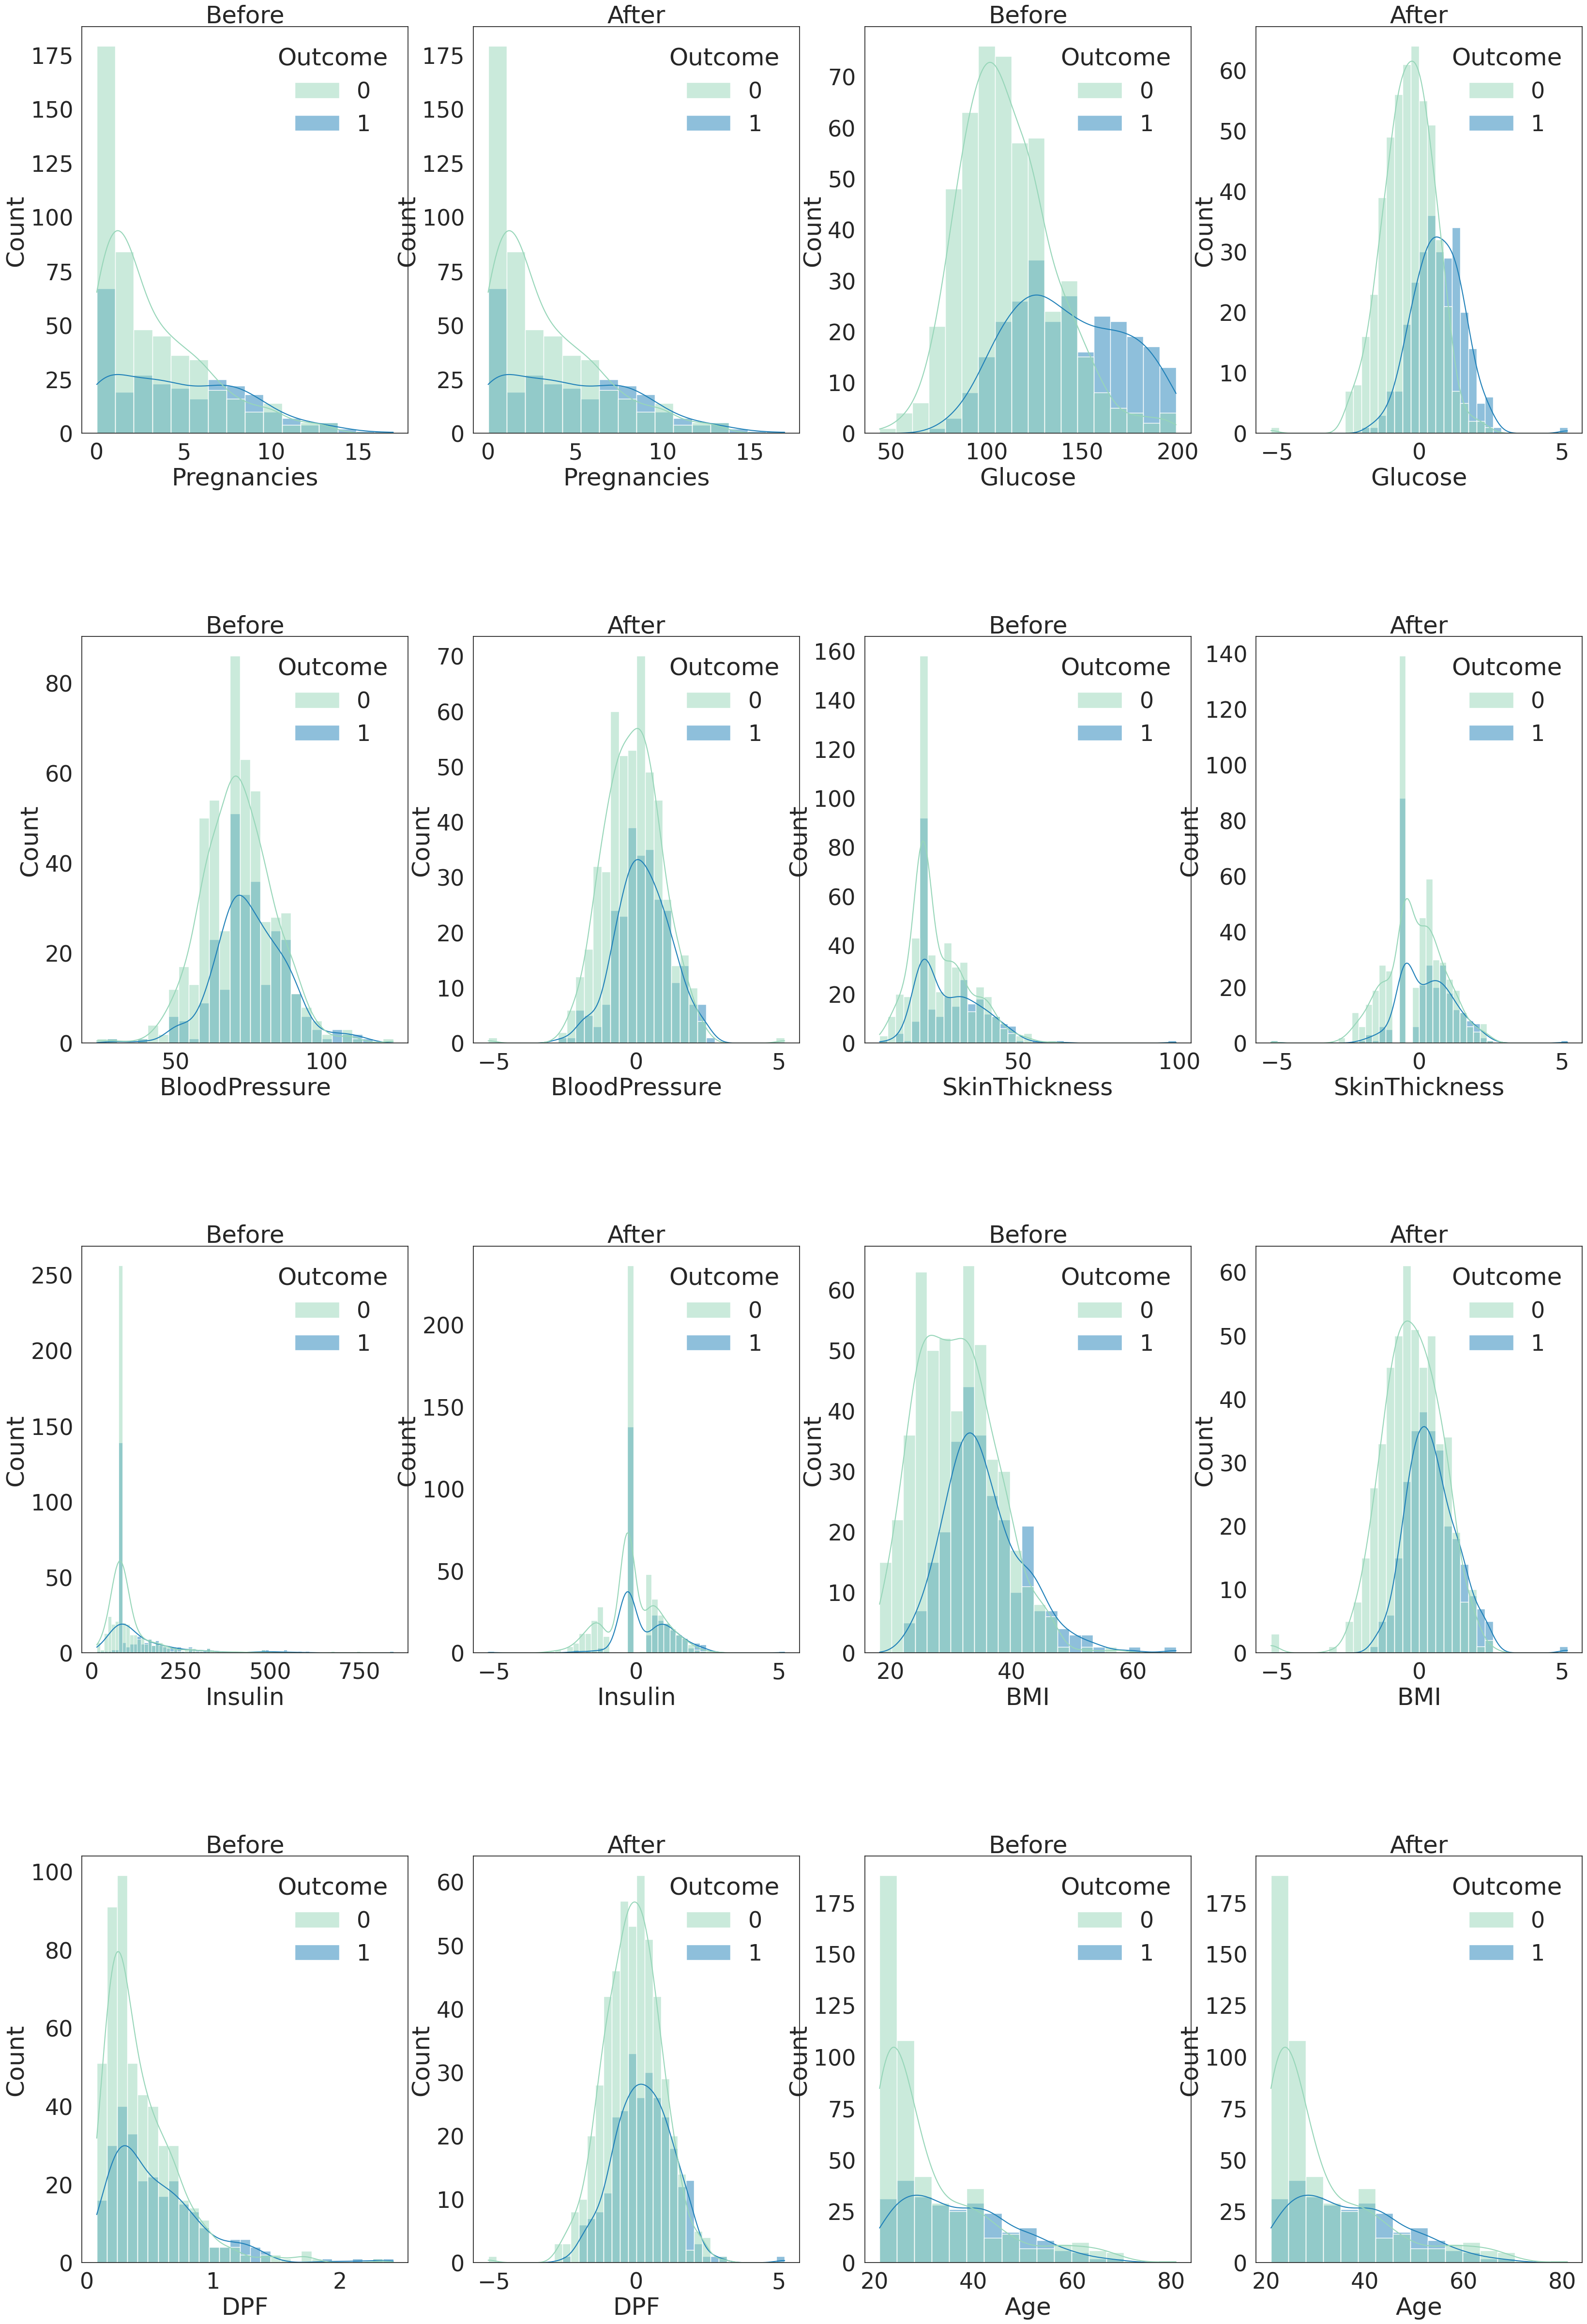

In [28]:
rcParams['figure.figsize'] = 40,60
sns.set(font_scale = 3)
sns.set_style("white")
sns.set_palette("bright")
plt.subplots_adjust(hspace=0.5)
i = 1;
for name in feature_names:
    plt.subplot(4,4,i)
    plt.title("Before")
    sns.histplot(data=df, x=name, hue="Outcome",kde=True,palette="YlGnBu")
    plt.subplot(4,4,i+1)
    plt.title("After")
    sns.histplot(data=df_scaled, x=name, hue="Outcome",kde=True,palette="YlGnBu")
    i = i + 2

In [29]:
df_stats3 = compute_stat(df_scaled)
df_styled3 = (df_stats3.style.applymap(skew_warning, subset=['Skewness']).applymap(kurtosis_warning, subset=['Kurtosis']))
df_styled3

##QQ Plot

A Quantile-Quantile (QQ) plot is a graphical tool used to assess if a dataset follows a particular theoretical distribution. In the QQ plot, the x-axis represents the quantiles from the theoretical distribution, and the y-axis shows the quantiles from the observed data. If the points in the QQ plot fall approximately along a straight line (usually a 45-degree line), it suggests that the data are distributed in a way that is similar to the theoretical distribution.

**How QQ Plots Work**

Suppose you have a dataset X and you want to test if it follows a specific distribution (e.g., Normal, Exponential, etc.).

1. Sort the data in ascending order.
2. Calculate the empirical quantiles for the data. These are the y-values in the QQ plot.
3. Calculate the corresponding quantiles from the theoretical distribution you're comparing against. These become the x-values.
4. Plot the empirical quantiles against the theoretical quantiles.

**Interpretation**

* Data falls along the line: If the data points roughly follow the 45-degree line, this indicates that the sample distribution is similar to the theoretical distribution.

* Data deviates at the ends: If the data points deviate from the line at the ends, it suggests that the sample has "heavier" tails than the normal distribution (or whatever distribution you're comparing against).

* Systematic curve: If the data points form a curve, this could indicate skewness in the data.


In an ideal QQ plot for data following a Normal distribution. The points would perfectly align along the 45-degree line, which starts at the origin.

In a QQ plot for data that is not Normally distributed. The points might curve away from the 45-degree line, indicating that the data distribution is skewed or has kurtosis different from that of a normal distribution.

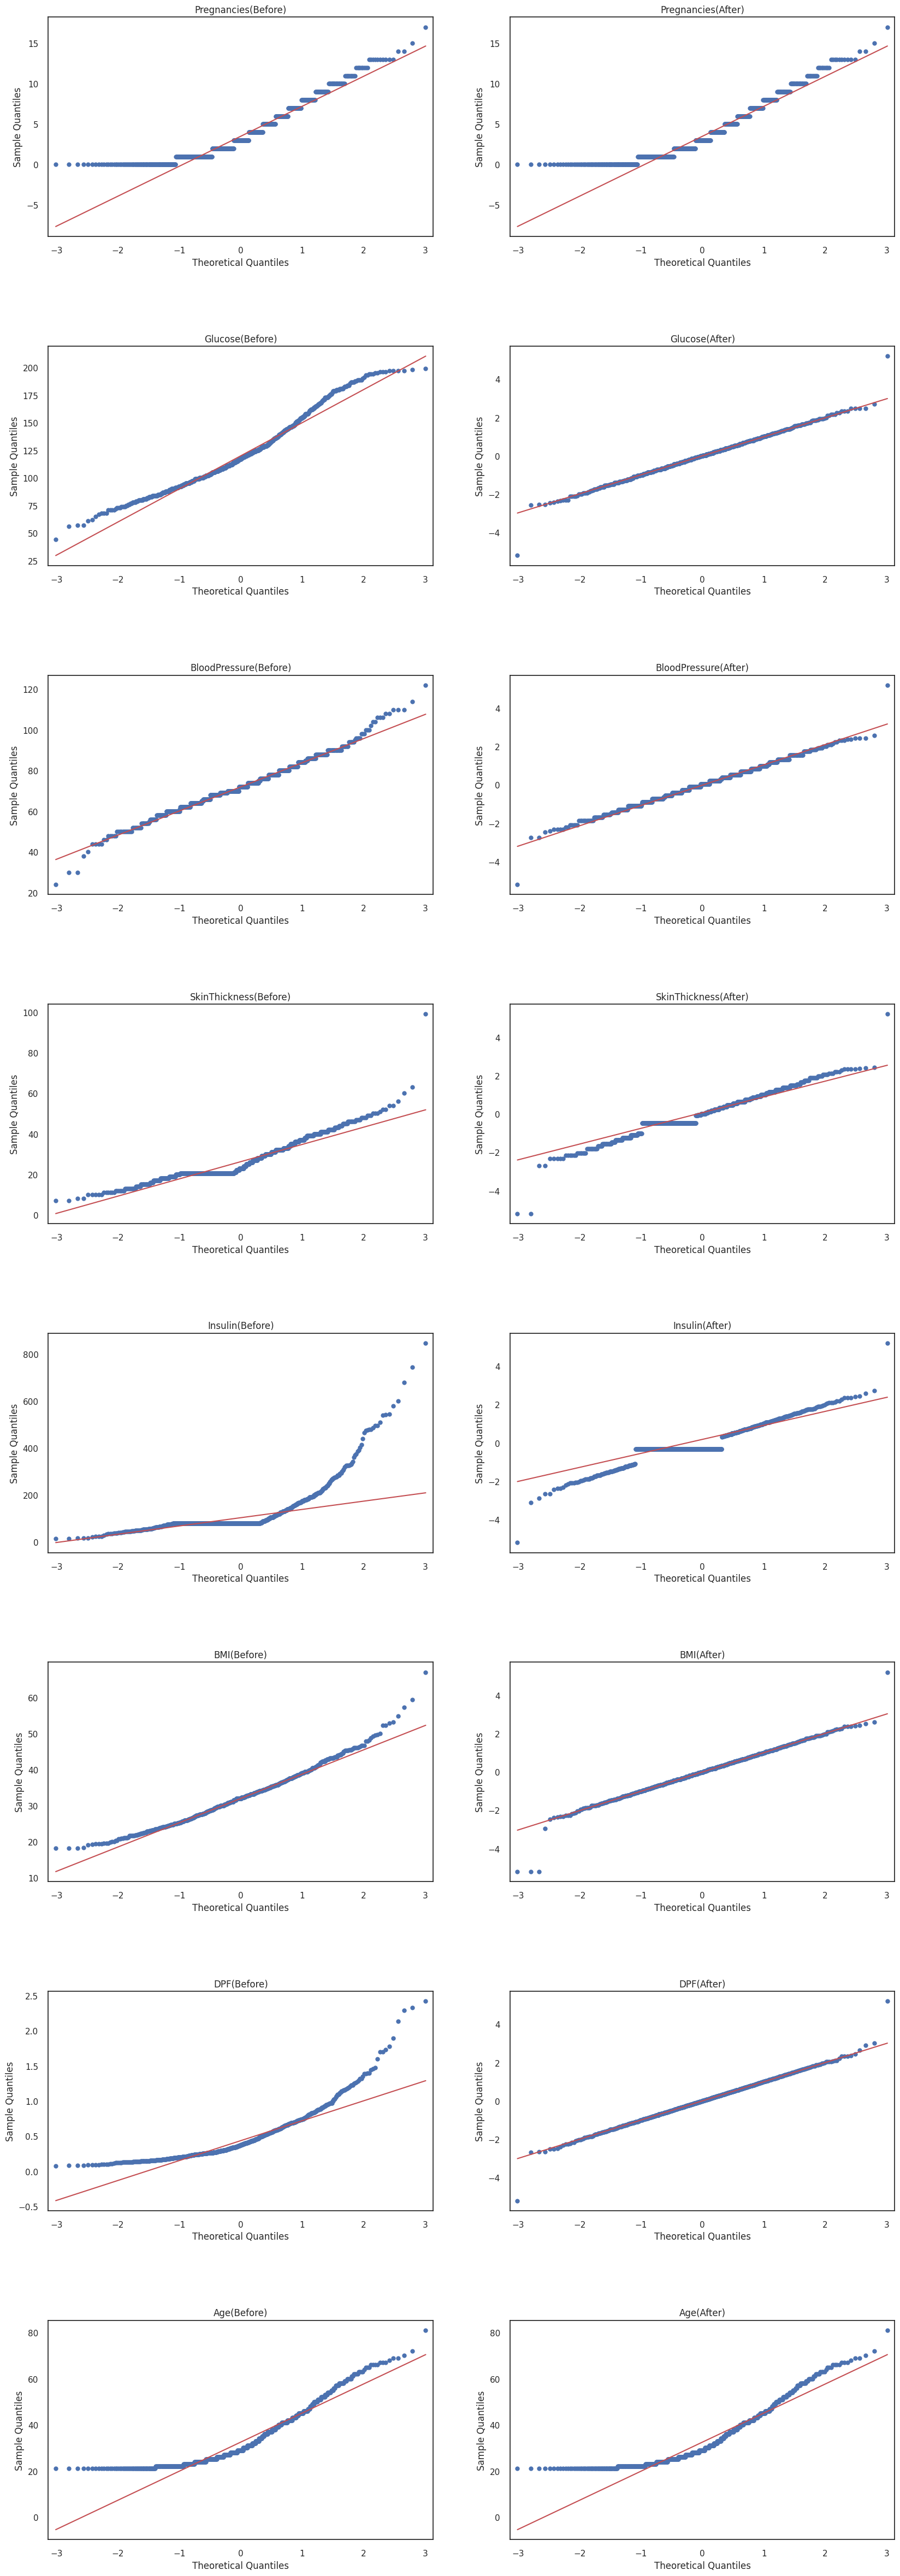

In [30]:
import statsmodels.api as sm
import pylab as py
import matplotlib.pyplot as plt

rcParams['figure.figsize'] = 20,60
sns.set(font_scale = 1)
sns.set_style("white")
total_features = len(feature_names)
fig, axes = plt.subplots(total_features, 2)
plt.subplots_adjust(hspace=.5)

for i,col in zip(range(total_features),feature_names):
    sm.qqplot(df[col], line ='q',ax=axes[i,0])
    title = col + "(Before)"
    axes[i,0].set_title(title)
    sm.qqplot(df_scaled[col], line ='q',ax=axes[i,1])
    title = col + "(After)"
    axes[i,1].set_title(title)

plt.show()

#Classifiers

We will use the processed version of the dataset to perform classification and compare it to the results of the unprocessed version of the dataset.

In [31]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

classifiers = { "LogisiticRegression": LogisticRegression(max_iter=500),
                "KNearest": KNeighborsClassifier(),
                "Support Vector Classifier": SVC(),
                "DecisionTreeClassifier": DecisionTreeClassifier()
              }

**Original Data**

In [32]:
# Split data into training and test sets
X = df.drop('Outcome', axis=1)
y = df['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=44)

# Turn the values into an array for feeding the classification algorithms.
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5)
    print("Classifiers: ", classifier.__class__.__name__, "Has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")


Classifiers:  LogisticRegression Has a training score of 75.0 % accuracy score
Classifiers:  KNeighborsClassifier Has a training score of 69.0 % accuracy score
Classifiers:  SVC Has a training score of 75.0 % accuracy score
Classifiers:  DecisionTreeClassifier Has a training score of 67.0 % accuracy score


**Transformed/Processed Data**

In [33]:
# Split data into training and test sets
X = df_scaled.drop('Outcome', axis=1)
y = df_scaled['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=44)

# Turn the values into an array for feeding the classification algorithms.
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5)
    print("Classifiers: ", classifier.__class__.__name__, "Has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")


Classifiers:  LogisticRegression Has a training score of 74.0 % accuracy score
Classifiers:  KNeighborsClassifier Has a training score of 68.0 % accuracy score
Classifiers:  SVC Has a training score of 67.0 % accuracy score
Classifiers:  DecisionTreeClassifier Has a training score of 67.0 % accuracy score


#Visualize Dataset

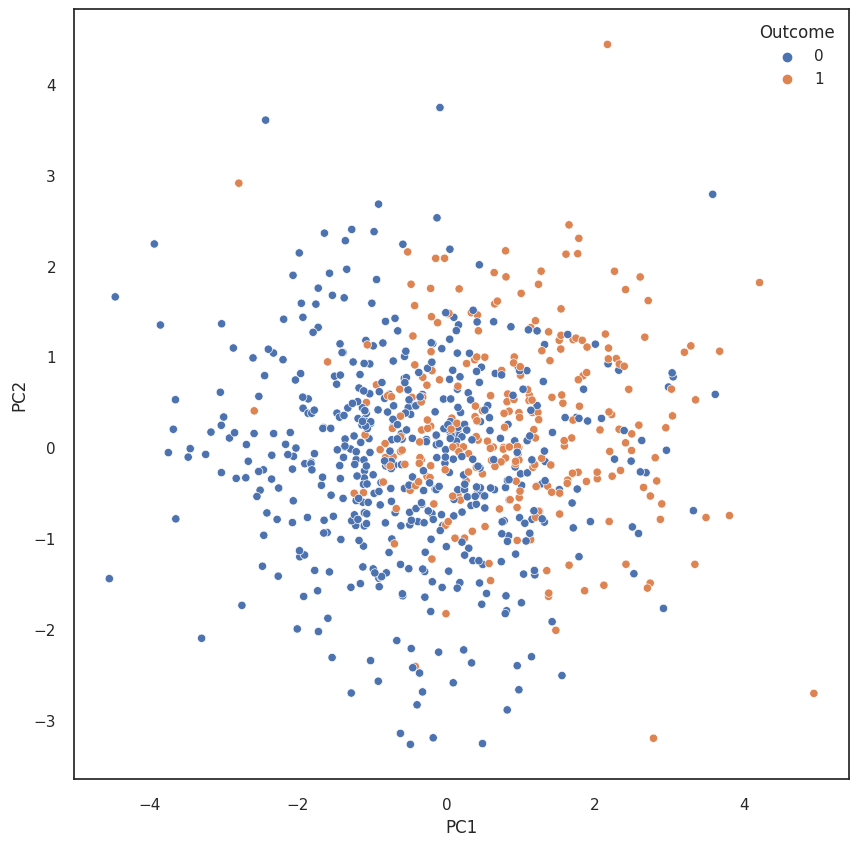

In [34]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X_scaled)
df_pca = pd.DataFrame(X_reduced, columns=['PC1', 'PC2'])
df_pca['Outcome'] = df["Outcome"]  # Assume `y` contains labels for each data point

# Plot
plt.figure(figsize=(10, 10))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='Outcome')
plt.show()


## PCA Visualization Interpretation

The given plot visualizes an 8-dimensional dataset reduced to 2 dimensions using PCA. The two principal components, PC1 and PC2, are plotted on the x-axis and y-axis respectively. The data points are color-coded based on the 'Outcome' - whether a person is diabetic (1) or not (0). From this visualization, we can draw the following inference:

### 1. Overlap of Classes
There's a significant overlap between the diabetic and non-diabetic classes in the space defined by PC1 and PC2. This means in this 2D representation, there isn't a clear linear boundary that segregates the two groups perfectly.

### 2. Density and Clustering
Most of the data points are clustered around the center of the plot, especially between -2 and 2 on both axes. This dense region consists of a mix of both classes, making it challenging to differentiate between them solely based on these two principal components.

### 3. Spread Along PC1 vs. PC2
The data seems to have a broader spread along the PC1 axis than the PC2 axis. This suggests that PC1 might capture a more significant portion of the variance from the original data compared to PC2.

### 4. Outliers
There are a few outlier data points seen, especially towards the top-right and bottom-left corners of the plot. Both classes have such outliers, indicating extreme or rare observations in the original dataset.

### 5. Potential for Further Analysis
Given that there isn't a clear separation between the classes in this PCA visualization, it may be beneficial to explore other dimensionality reduction techniques, more complex classifiers, or delve deeper into feature engineering to discern patterns in higher dimensions.

In summary, while PCA provides a visual insight into the high-dimensional data, the distinction between diabetic and non-diabetic individuals in this representation appears complex, suggesting the need for more detailed analysis or modeling strategies.


#Model Training

##Model Creation

In [35]:
from pycaret.classification import *

In [36]:
clf1 = setup(data = df_scaled,
             target = 'Outcome',
             preprocess = False)

In [37]:
top5 = compare_models(sort='AUC',
                      n_select = 5,
                      exclude=["ridge","qda","lda","dt","dummy","lightgbm","xgboost"]
                      #exclude=['svm','knn','nb']
                     )

Processing:   0%|          | 0/41 [00:00<?, ?it/s]

1. Accuracy: This is the ratio of the correctly predicted instances to the total instances in the dataset. It's a general measure of a model's performance.

2. AUC: The Area Under the Curve (AUC) is a metric used for classification problems. Higher the AUC, the better the model is at predicting 0 classes as 0 and 1 classes as 1. An excellent model has AUC near to the 1 which means it has a good measure of separability. A poor model has an AUC near 0 which means it has the worst measure of separability. In fact, it means it is reciprocating the result. It is predicting 0s as 1s and 1s as 0s. And when AUC is 0.5, it means the model has no class separation capacity whatsoever.

3. Recall: Also known as Sensitivity, True Positive Rate, or Hit Rate. It measures the proportion of actual positive cases that were identified correctly. Recall = TP / (TP + FN).

4. Prec.: This stands for Precision, which is the ratio of correctly predicted positive observations to the total predicted positives. Precision = TP / (TP + FP).

5. F1: The F1 Score is the harmonic mean of precision and recall. It takes both false positives and false negatives into account and ranges between 0 and 1. F1 Score is a good way to summarize the evaluation metrics into a single number.

6. Kappa: Cohen's Kappa is a statistic that measures the degree of agreement between the predicted and actual categories of a classification problem. It accounts for the possibility of the agreement occurring by chance.

7. MCC: Matthews Correlation Coefficient is another evaluation metric for classification. It takes into account true and false positives and negatives and is generally regarded as a balanced measure that can be used even if the classes are of very different sizes.

8. TT (Sec): This stands for "Time Taken (Seconds)" and indicates the amount of time in seconds it took to train the respective model.

**Create Models**

This function trains and evaluates the performance of a given estimator using cross validation. The output of this function is a score grid with CV scores by fold.

In [38]:
lda = create_model('lda')
lr = create_model('lr')
et = create_model('et')
rf = create_model('rf')
gbc = create_model('gbc')
dt = create_model("dt")

Processing:   0%|          | 0/4 [00:00<?, ?it/s]

Processing:   0%|          | 0/4 [00:00<?, ?it/s]

Processing:   0%|          | 0/4 [00:00<?, ?it/s]

Processing:   0%|          | 0/4 [00:00<?, ?it/s]

Processing:   0%|          | 0/4 [00:00<?, ?it/s]

Processing:   0%|          | 0/4 [00:00<?, ?it/s]

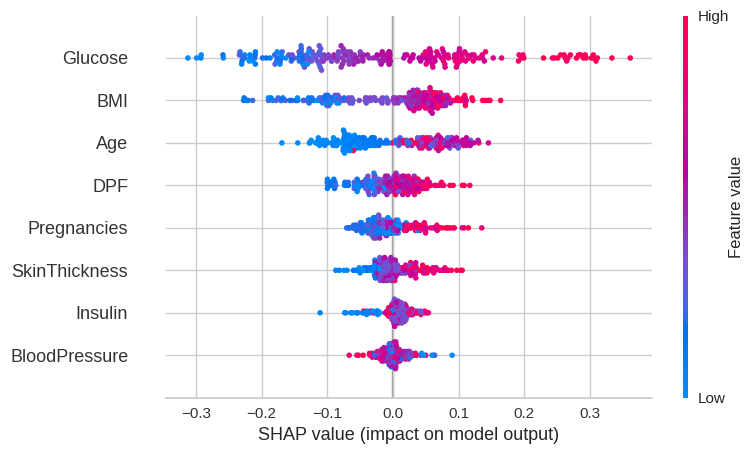

In [36]:
interpret_model(rf)

For the Random Forest Classifier model, Glucose is the most important feature.

## Stacking

In [41]:
stack_model = stack_models(estimator_list = top5, meta_model = top5[0],optimize = 'AUC')

Processing:   0%|          | 0/6 [00:00<?, ?it/s]

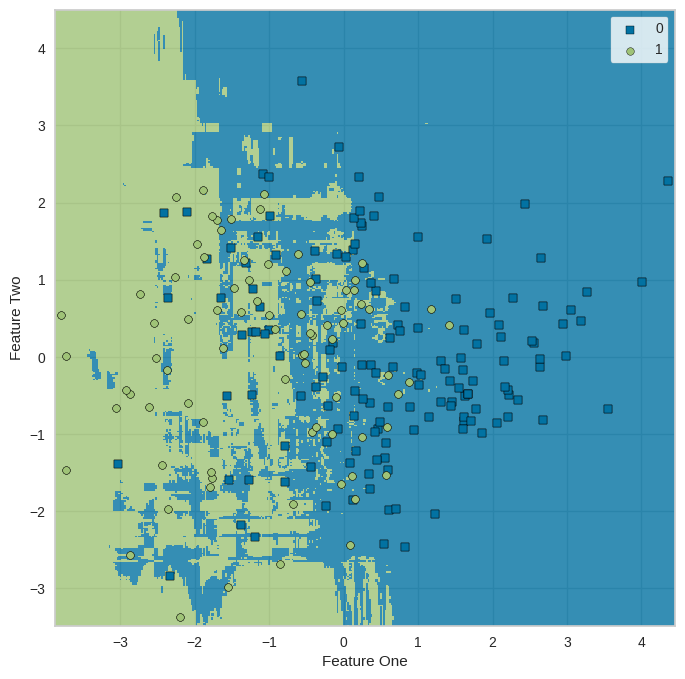

In [38]:
plt.figure(figsize=(8, 8))
plot_model(stack_model, plot='boundary')

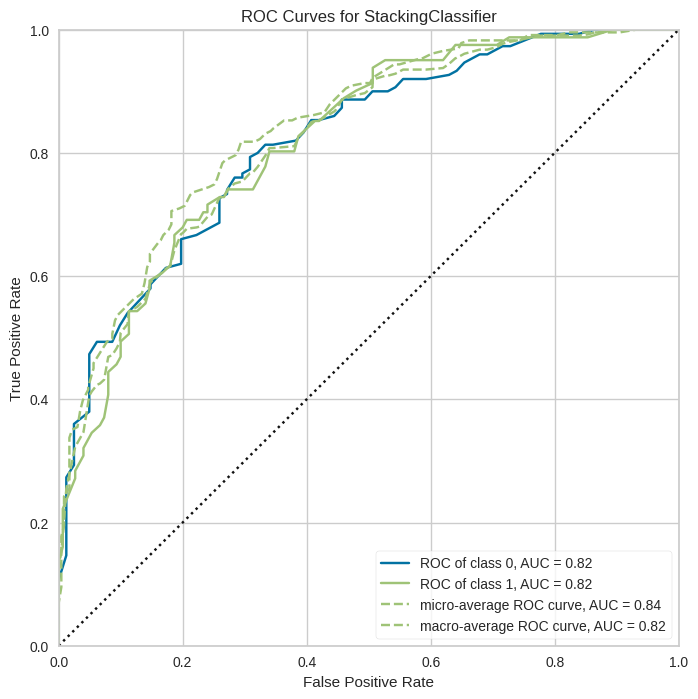

In [39]:
plt.figure(figsize=(8, 8))
plot_model(stack_model, plot = 'auc')

Reference:
1. [Classification: ROC Curve and AUC](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc#:~:text=An%20ROC%20curve%20(receiver%20operating,True%20Positive%20Rate)
2. [Understanding AUC - ROC Curve](https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5)

**ROC Curve and AUC**

The Receiver Operating Characteristic (ROC) curve is a graphical representation used to evaluate the performance of a binary classification model. The curve plots two parameters:


1. True Positive Rate (TPR): Also known as Sensitivity or Recall, this is plotted on the Y-axis. It's calculated as
\begin{equation}
\text{TPR} = \frac{\text{True Positives (TP)}}{\text{True Positives (TP)} + \text{False Negatives (FN)}}.
\end{equation}

2. False Positive Rate (FPR): This is plotted on the X-axis and calculated as
\begin{equation}
\text{FPR} = \frac{\text{False Positives (FP)}}{\text{False Positives (FP)} + \text{True Negatives (TN)}}.
\end{equation}

The ROC curve is generated by varying the decision threshold for classification and plotting TPR against FPR at each threshold. A perfect classifier would have a curve that goes straight up the Y-axis and then along the X-axis, which means it correctly classifies all the positive and negative cases.

**Relation to AUC**

AUC stands for ``Area Under the ROC Curve.'' It provides a single numeric value summarizing the overall performance of the classification model, making it easier to compare different classifiers. The AUC ranges from 0 to 1, where:
* An AUC of 0.5 corresponds to a model that is no better than random classification.
* An AUC of 1 indicates perfect classification.
* An AUC between 0.5 and 1 suggests that the model has some discriminatory power, with higher values indicating better performance.

AUC is a good metric when:
* You need a summary metric to compare different models.
* Your dataset has imbalanced classes.
* You want to evaluate a model's performance across different decision thresholds.

Here's how to interpret the AUC value:

\begin{aligned}
    0.5 \leq \text{AUC} < 0.6 &: \text{Poor} \\
    0.6 \leq \text{AUC} < 0.7 &: \text{Fair} \\
    0.7 \leq \text{AUC} < 0.8 &: \text{Good} \\
    0.8 \leq \text{AUC} < 0.9 &: \text{Very Good} \\
    0.9 \leq \text{AUC} \leq 1.0 &: \text{Excellent}
\end{aligned}

By evaluating both the ROC curve and the AUC, you can get a comprehensive understanding of your model's performance in terms of both its discrimination capabilities and its performance across various decision thresholds.

**ROC Curve and Perfect Separability**

For "perfect separability," the ROC curve moves straight up the y-axis before proceeding horizontally along the x-axis. This trajectory is indicative of impeccable classification because the True Positive Rate becomes 1 before any increment in the False Positive Rate.

Here's a step-by-step breakdown:

1. Starting Point (0,0):
This implies both TPR (True Positive Rate) and FPR (False Positive Rate) are zero. The threshold is set so high that every prediction is negative, resulting in neither true positives nor false positives.

2. Perfect Classifier:
   - **Vertical Movement**: As the threshold decreases, and positive samples are rightly predicted before any negative samples are mispredicted as positive, the curve shifts straight up the y-axis. The TPR increases without changing the FPR, indicating that our classifier is accurately predicting positive samples without any errors.
   
   - **Horizontal Movement**: Once all the positive samples are correctly classified, any further reduction in the threshold will only affect the negative samples, pushing the curve horizontally on the x-axis. Here, while TPR remains constant at 1, FPR begins to increase since more negative samples are misclassified as positive. For a perfect classifier, this horizontal movement happens only after reaching the graph's top (i.e., TPR = 1).

3. Ending Point (1,1):
This position implies that every sample is predicted as positive, making both TPR and FPR equal to 1. All positive samples are correctly predicted, but all negative samples are also wrongly identified as positive.

In essence, for perfect separability in the ROC curve, the goal is to achieve a 100% True Positive Rate without any False Positives. A common descriptive phrase, "moves from 0 to 1 on the y-axis and then 0 to 1 on the x-axis," might sound as if FPR increases first. However, the accurate interpretation is that the TPR rises to 1 (perfect sensitivity) before the FPR starts increasing.



In [42]:
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)

    roc_auc = roc_auc_score(y_test, pred_proba)

    # ROC-AUC print
    print('accuracy: {0:.4f}, precision: {1:.4f}, recall: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))
    return confusion

In [43]:
#prediction
pred = stack_model.predict(X_test)
pred_proba = stack_model.predict_proba(X_test)[:,1]
#Accuracy
confusion_stack = get_clf_eval(y_test,pred,pred_proba)

accuracy: 0.9010, precision: 0.9394, recall: 0.8052,    F1: 0.8671, AUC:0.9596


Text(0.5, 1.0, 'Probability density plots')

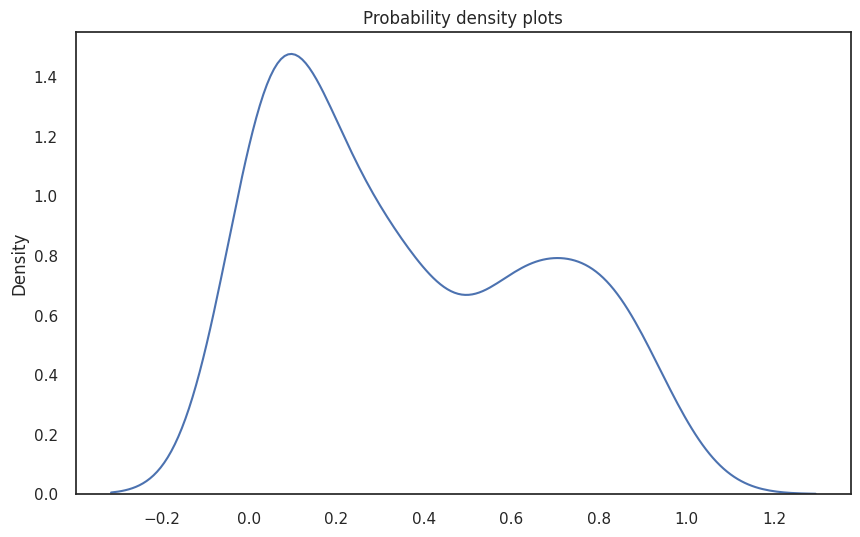

In [46]:
plt.figure(figsize=(10,6))
sns.kdeplot(pred_proba,label="lda")
plt.title("Probability density plots")


In [42]:
#pred = lda.predict(X_test)
#pred_proba = lda.predict_proba(X_test)[:,1]
#confusion_stack = get_clf_eval(y_test,pred,pred_proba)
stack_model

StackingClassifier(cv=5,
                   estimators=[('Extra Trees Classifier',
                                ExtraTreesClassifier(bootstrap=False,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                                     criterion='gini',
                                                     max_depth=None,
                                                     max_features='sqrt',
                                                     max_leaf_nodes=None,
                                                     max_samples=None,
                                                     min_impurity_decrease=0.0,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
                                                     n_estimators=100,
                                                     n_jobs=-1, oob_score=F...
                                                        ccp_alpha=0.0,
                                                        class_weight=None,
                                                        criterion='gini',
                                                        max_depth=None,
                                                        max_features='sqrt',
                                                        max_leaf_nodes=None,
                                                        max_samples=None,
                                                        min_impurity_decrease=0.0,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        n_estimators=100,
                                                        n_jobs=-1,
                                                        oob_score=False,
                                                        random_state=4027,
                                                        verbose=0,
                                                        warm_start=False),
                   n_jobs=-1, passthrough=True, stack_method='auto', verbose=0)

Text(0.5, 1.0, 'Confusion Matrix (Stacking)')

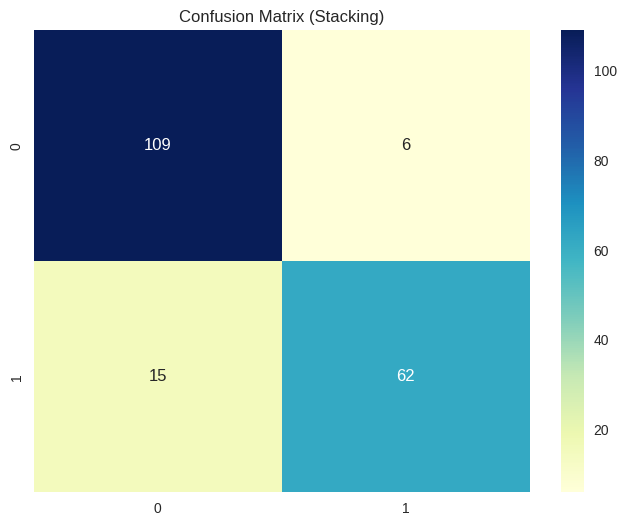

In [43]:
plt.figure(figsize=(8, 6))
ax = sns.heatmap(confusion_stack, cmap = 'YlGnBu',annot = True, fmt='d')
ax.set_title('Confusion Matrix (Stacking)')

## Soft Voting

In [45]:
soft = blend_models(estimator_list = top5, optimize = 'AUC',method = 'soft')

Processing:   0%|          | 0/6 [00:00<?, ?it/s]

Parameter "method": ‘hard’ uses predicted class labels for majority rule voting. ‘soft’, predicts the class label based on the argmax of the sums of the predicted probabilities, which is recommended for an ensemble of well-calibrated classifiers. Default value, ‘auto’, will try to use ‘soft’ and fall back to ‘hard’ if the former is not supported.

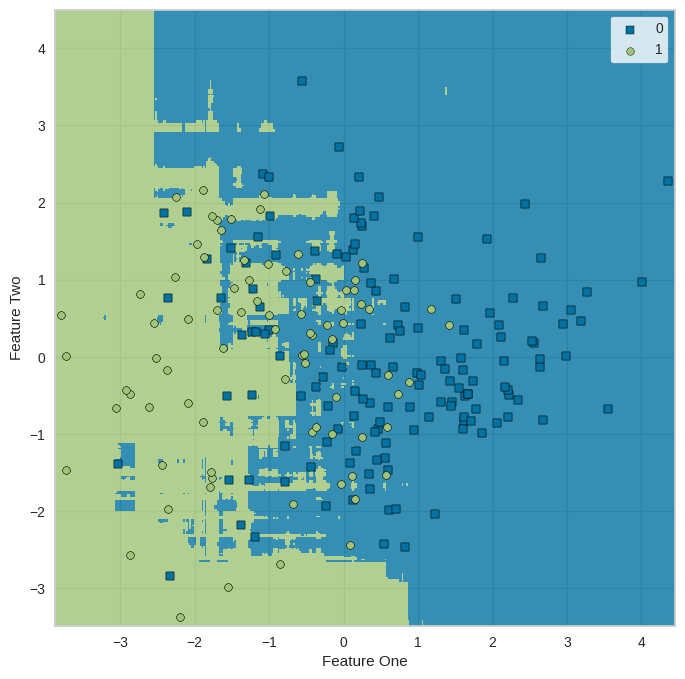

In [46]:
# @title
plt.figure(figsize=(8, 8))
plot_model(soft, plot='boundary')

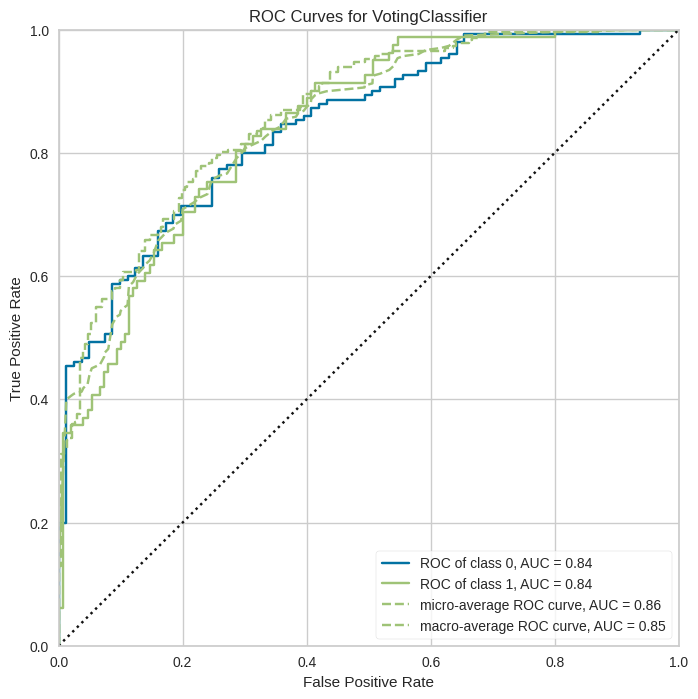

In [47]:
plt.figure(figsize=(8, 8))
plot_model(soft, plot = 'auc')

In [48]:
#prediction
pred = soft.predict(X_test)
pred_proba = soft.predict_proba(X_test)[:,1]
#Accuracy
confusion_soft = get_clf_eval(y_test,pred,pred_proba)

accuracy: 0.9010, precision: 0.9265, recall: 0.8182,    F1: 0.8690, AUC:0.9791


Text(0.5, 1.0, 'Confusion Matrix (Soft Blending)')

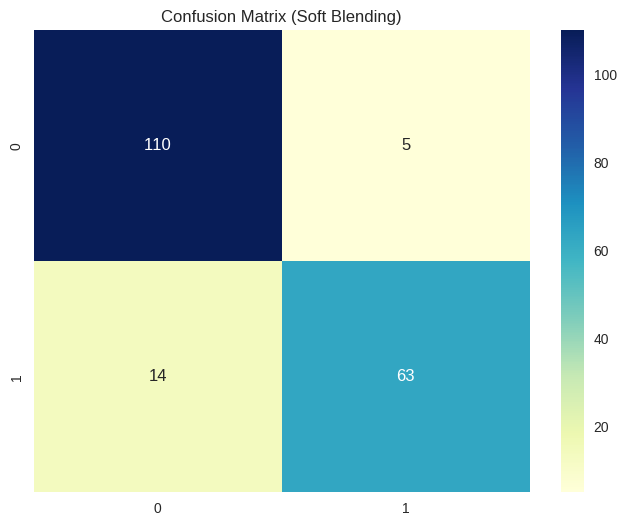

In [49]:
plt.figure(figsize=(8, 6))
ax = sns.heatmap(confusion_soft, cmap = 'YlGnBu',annot = True, fmt='d')
ax.set_title('Confusion Matrix (Soft Blending)')

## Hard Voting

In [50]:
blend_hard = blend_models(estimator_list = top5, optimize = 'AUC',method = 'hard')

Processing:   0%|          | 0/6 [00:00<?, ?it/s]

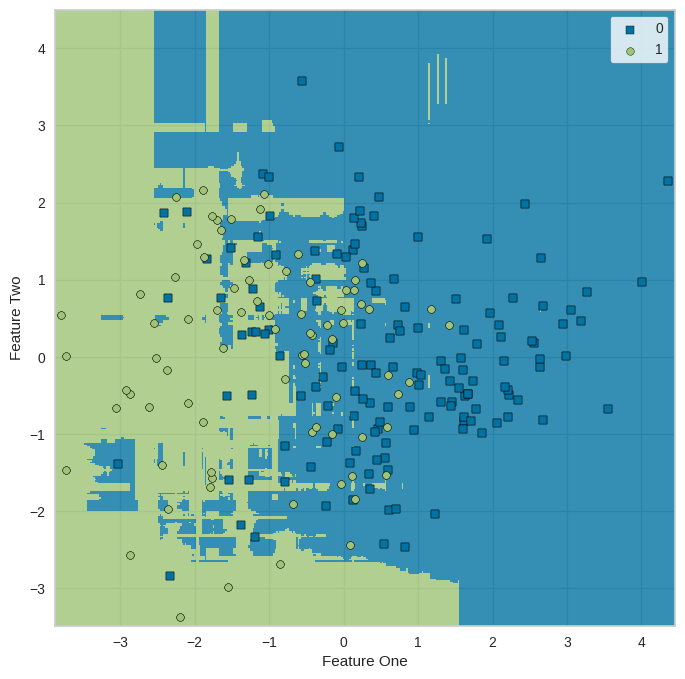

In [51]:
plt.figure(figsize=(8, 8))
plot_model(blend_hard, plot='boundary')

In [52]:
#prediction
pred = blend_hard.predict(X_test)
#Accuracy
confusion_hard = confusion_matrix( y_test, pred)
accuracy = accuracy_score(y_test , pred)
precision = precision_score(y_test , pred)
recall = recall_score(y_test , pred)
f1 = f1_score(y_test,pred)
print('accuracy: {0:.4f}, precision: {1:.4f}, recall: {2:.4f},\
F1: {3:.4f}'.format(accuracy, precision, recall, f1))

accuracy: 0.9115, precision: 0.9412, recall: 0.8312,F1: 0.8828


Text(0.5, 1.0, 'Confusion Matrix (Hard Blending)')

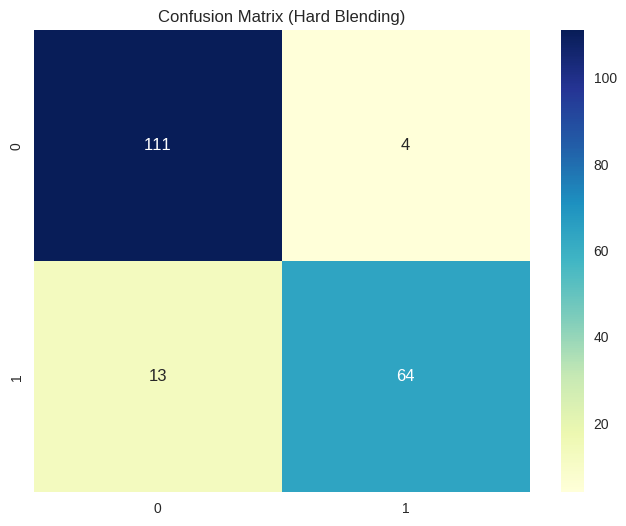

In [53]:
plt.figure(figsize=(8, 6))
ax = sns.heatmap(confusion_hard, cmap = 'YlGnBu',annot = True, fmt='d')
ax.set_title('Confusion Matrix (Hard Blending)')

## Calibrating the model

###References:

* [Calibration Techniques and it’s importance in Machine Learning](https://kingsubham27.medium.com/calibration-techniques-and-its-importance-in-machine-learning-71bec997b661)

In [54]:
cali_model = calibrate_model(soft)

Processing:   0%|          | 0/6 [00:00<?, ?it/s]

In [55]:
cali_model

CalibratedClassifierCV(base_estimator=VotingClassifier(estimators=[('Extra '
                                                                    'Trees '
                                                                    'Classifier',
                                                                    ExtraTreesClassifier(bootstrap=False,
                                                                                         ccp_alpha=0.0,
                                                                                         class_weight=None,
                                                                                         criterion='gini',
                                                                                         max_depth=None,
                                                                                         max_features='sqrt',
                                                                                         max_leaf_nodes=None,
                                                                                         max_samples=None,
                                                                                         min_impurity_decrease=0.0,
                                                                                         min_samples_leaf=1,
                                                                                         min_samples_split=2,
                                                                                         min_weight_fraction_leaf=0.0,
                                                                                         n_e...
                                                                                               min_weight_fraction_leaf=0.0,
                                                                                               n_estimators=100,
                                                                                               n_iter_no_change=None,
                                                                                               random_state=4027,
                                                                                               subsample=1.0,
                                                                                               tol=0.0001,
                                                                                               validation_fraction=0.1,
                                                                                               verbose=0,
                                                                                               warm_start=False)),
                                                                   ('Naive '
                                                                    'Bayes',
                                                                    GaussianNB(priors=None,
                                                                               var_smoothing=1e-09))],
                                                       flatten_transform=True,
                                                       n_jobs=-1, verbose=False,
                                                       voting='soft',
                                                       weights=None),
                       cv=5, ensemble=True, estimator=None, method='sigmoid',
                       n_jobs=None)

### Model Calibration in PyCaret

In PyCaret, the `calibrate_model` function calibrates the probabilities of a classification model. Calibration ensures that the predicted probabilities of a model align more closely with the actual probability of the event.

###Why is Calibration Important?

Some models may produce raw scores or probabilities that do not accurately represent the true likelihood of an event. For instance, if a model assigns an instance a probability of 0.8 for the positive class, but only 70% of instances with that score actually belong to the positive class, then the model is "miscalibrated". Calibration helps adjust these probabilities.

###Calibration Techniques:

1. **Platt Scaling**:
    - Applies a logistic regression model to the model's scores.
    - Commonly used with Support Vector Machines.
    
2. **Isotonic Regression**:
    - Uses a piecewise constant non-decreasing function.
    - Generally more flexible than Platt Scaling.

In PyCaret, Platt Scaling is the default technique. However, users can also choose Isotonic Regression.

## Calibration Techniques in Machine Learning

Reference: [Calibration Techniques and it’s importance in Machine Learning](https://kingsubham27.medium.com/calibration-techniques-and-its-importance-in-machine-learning-71bec997b661)

Calibration is the process of refining the predicted probabilities of a classification model to ensure they align closely with the true probabilities of the outcomes.

### 1. **Platt Scaling**:

Platt scaling, named after John Platt, is a logistic regression on the predicted probabilities of a model. It's especially useful when the output of the classifiers isn't a probability (like Support Vector Machines).

#### How it works:

- First, the model is trained and produces a raw score for each instance (like the distance from the decision boundary in SVMs).
- These scores are then used as input features for a logistic regression model, which is trained to predict the true class labels.
- The output of the logistic regression model is a probability between 0 and 1.

This logistic calibration ensures the output probabilities better represent the true likelihood of positive class instances.

### 2. **Isotonic Regression**:

Unlike Platt Scaling, which fits a logistic curve to the predicted scores, isotonic regression fits a non-parametric, piecewise constant function. This method can capture more complex calibration curves.

#### How it works:

- Start by sorting the instances by their predicted scores.
- A non-decreasing step function is fit to these scores in a way that minimizes the mean squared error to the true class labels.
- The resulting function maps raw model scores to calibrated probabilities.

Isotonic regression is more flexible than Platt Scaling and can be particularly useful when calibration curves exhibit a non-logistic shape. However, its flexibility can also lead to overfitting, especially with limited data.

### Using Calibration in PyCaret:

In PyCaret, the `calibrate_model` function provides an easy way to apply these calibration techniques:

```python
from pycaret.classification import *
clf1 = setup(data, target = 'target_column')
lr = create_model('lr')  # Example: creating a logistic regression model
calibrated_lr = calibrate_model(lr, method='isotonic')  # Using isotonic regression for calibration


<Figure size 800x800 with 0 Axes>

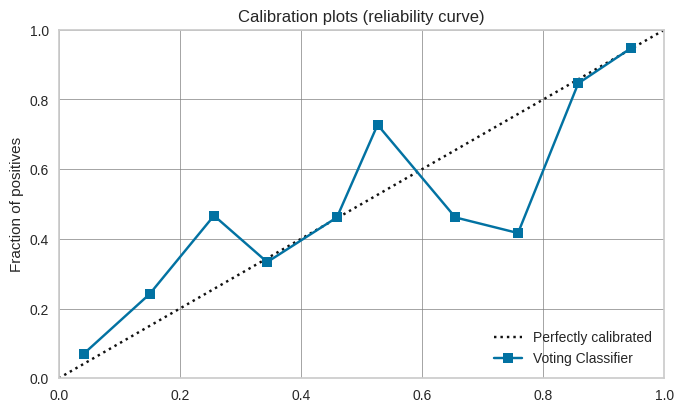

In [56]:
plt.figure(figsize=(8, 8))
plot_model(cali_model, plot='calibration')

## Finalizing the last model

In [57]:
final_model = finalize_model(cali_model)

In [58]:
final_model

Pipeline(memory=Memory(location=None),
         steps=[('placeholder', None),
                ('actual_estimator',
                 CalibratedClassifierCV(base_estimator=VotingClassifier(estimators=[('Extra '
                                                                                     'Trees '
                                                                                     'Classifier',
                                                                                     ExtraTreesClassifier(bootstrap=False,
                                                                                                          ccp_alpha=0.0,
                                                                                                          class_weight=None,
                                                                                                          criterion='gini',
                                                                                                          max_depth=None,
                                                                                                          max_features='sqrt',
                                                                                                          max_leaf_nodes=None,
                                                                                                          max_samples=None,
                                                                                                          min_impurit...
                                                                                                                n_estimators=100,
                                                                                                                n_iter_no_change=None,
                                                                                                                random_state=4027,
                                                                                                                subsample=1.0,
                                                                                                                tol=0.0001,
                                                                                                                validation_fraction=0.1,
                                                                                                                verbose=0,
                                                                                                                warm_start=False)),
                                                                                    ('Naive '
                                                                                     'Bayes',
                                                                                     GaussianNB(priors=None,
                                                                                                var_smoothing=1e-09))],
                                                                        flatten_transform=True,
                                                                        n_jobs=-1,
                                                                        verbose=False,
                                                                        voting='soft',
                                                                        weights=None),
                                        cv=5, ensemble=True, estimator=None,
                                        method='sigmoid', n_jobs=None))],
         verbose=False)

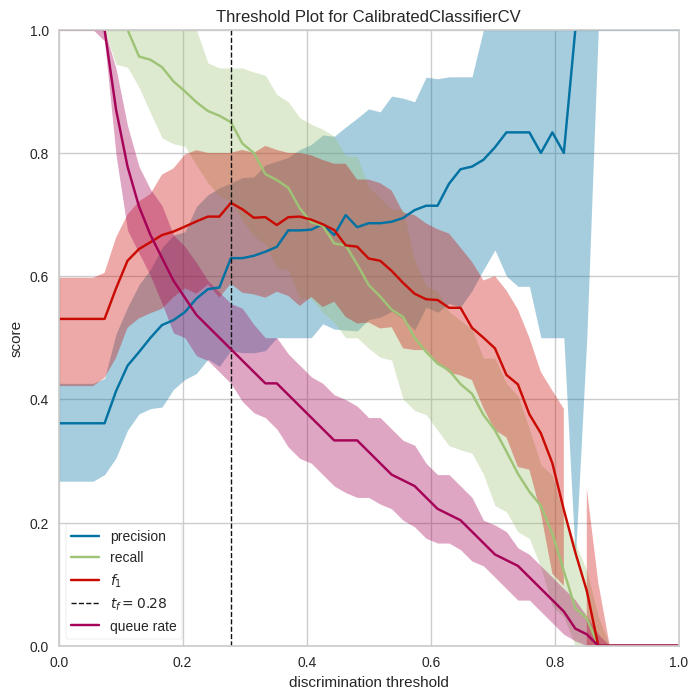

In [59]:
plt.figure(figsize=(8, 8))
plot_model(final_model, plot='threshold')

[DT plot: Finding the Optimal Discrimination Threshold for Binary Classifier](https://towardsdatascience.com/dt-plot-finding-the-optimal-discrimination-threshold-for-binary-classifier-c3f326d6326f)

## Precision and Recall Trade-off

**Precision** and **recall** are two commonly used metrics in classification tasks, especially when dealing with imbalanced datasets. They often show a trade-off in many practical scenarios:

### Definitions

- **Precision** (also known as Positive Predictive Value) is given by:
  \begin{equation}
    \text{Precision} = \frac{\text{TP}}{\text{TP} + \text{FP}}
  \end{equation}
  
- **Recall** (also known as Sensitivity or True Positive Rate) is given by:
  \begin{equation}
    \text{Recall} = \frac{\text{TP}}{\text{TP} + \text{FN}}
  \end{equation}

### Threshold Adjustment

The trade-off is often evident when adjusting the threshold for predicting positive cases in probabilistic classifiers:

- Lowering the threshold increases both TP and FP, which typically increases recall but might decrease precision.
- Raising the threshold reduces both TP and FP, leading to higher precision but potentially reducing recall.

### Illustration

If almost all cases are predicted as positive, recall will be very high, but precision will be low due to many negative cases being incorrectly predicted as positive.

### Precision-Recall Curve

The trade-off can be visualized using a Precision-Recall curve. For each threshold, a point on this curve is plotted. Ideally, the curve goes straight up the y-axis and then straight right on the x-axis.

### Balancing Precision and Recall

Depending on the application, one might prioritize precision over recall or vice versa. In case of diabetes detection, high recall might be prioritized, whereas in email spam detection, high precision might be prioritized.


In [60]:
#prediction
pred = final_model.predict(X_test)
#Accuracy
final_model = confusion_matrix( y_test, pred)
accuracy = accuracy_score(y_test , pred)
precision = precision_score(y_test , pred)
recall = recall_score(y_test , pred)
f1 = f1_score(y_test,pred)
print('accuracy: {0:.4f}, precision: {1:.4f}, recall: {2:.4f},\
F1: {3:.4f}'.format(accuracy, precision, recall, f1))

accuracy: 0.9427, precision: 0.9714, recall: 0.8831,F1: 0.9252


Text(0.5, 1.0, 'Confusion Matrix (final_model)')

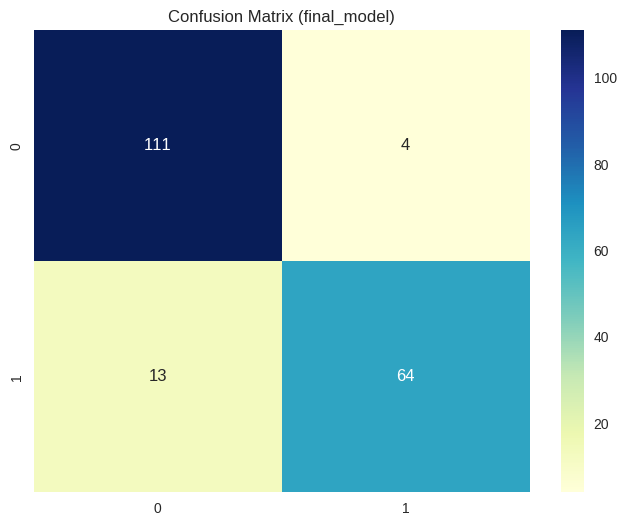

In [61]:
plt.figure(figsize=(8, 6))
ax = sns.heatmap(confusion_hard, cmap = 'YlGnBu',annot = True, fmt='d')
ax.set_title('Confusion Matrix (final_model)')